In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
# file renamings
import os

# directory containing the files
og_dir = os.getcwd()
directory = os.path.join(og_dir, 'data_files')
models_directory = os.path.join(og_dir, 'model_files')

os.chdir(directory)

# iterate over the files in the directory
for filename in os.getcwd():
    # do something
    # check if filename ends with 'Player Stats - OraclesElixir.csv'
    if filename.endswith(' - Player Stats - OraclesElixir.csv'):
        # remove 'Player Stats - OraclesElixir' from filename and keep the rest
        new_filename = filename.replace(' - Player Stats - OraclesElixir', '').strip()
        # construct the full path to the file
        filepath = os.path.join(directory, filename)
        new_filepath = os.path.join(directory, new_filename)
        # rename the file
        os.rename(filepath, new_filepath)


In [3]:
split_data = ["LCK 2022 Spring.csv", "LCK 2022 Summer.csv", "LCK 2021 Spring.csv", "LCK 2021 Summer.csv",
              "LCK 2020 Spring.csv", "LCK 2020 Summer.csv", "LCK 2019 Spring.csv", "LCK 2019 Summer.csv",
              "LCK 2018 Spring.csv", "LCK 2018 Summer.csv", "LCK 2017 Spring.csv", "LCK 2017 Summer.csv",
              "LCK 2016 Spring.csv", "LCK 2016 Summer.csv", "Champions 2015 Spring.csv", "Champions 2015 Summer.csv"]
mvp_data = ['2022_spring.csv', '2022_summer.csv', '2021_spring.csv', '2021_summer.csv',
            '2020_spring.csv', '2020_summer.csv', '2019_spring.csv', '2019_summer.csv',
            '2018_spring.csv', '2018_summer.csv', '2017_spring.csv', '2017_summer.csv',
            '2016_spring.csv', '2016_summer.csv', '2015_spring.csv', '2015_summer.csv']

splits = []

In [4]:
from statistics import mean

for index in range(0, len(split_data)):
    split = pd.read_csv(split_data[index])
    
    # filter out players with less than 10 games
    split = split[split['GP'] >= 10]
    
    # add a year and season indicator to each player data
    split['Year'] = str(split_data[index][4:8])
    split['Season'] = split_data[index][9:15]
    
    # special case where ShowMaker (the absolute monster) played ADC (10 games) (Ghost got benched)
    # and many more Mid in DWG for '21 Spring
    # his Pog points are counted the same, but he is represented as two separate roles
    # we take the decision to remove ShowMaker ADC from the list
    # when ShowMaker played ADC, his jungler Canyon filled into mid. During this time,
    # Malrang was trying out for the jungle role. He eventually left to join KOI (called Rogue at the time) 
    # in the LEC region 
    if split['Year'].iloc[0] == '2021' and split['Season'].iloc[0] == 'Summer':
        #print(split.shape)
        split = split[~((split['Player'] == 'ShowMaker') & (split['Pos'] == 'ADC'))]
        split = split[~((split['Player'] == 'Canyon') & (split['Pos'] == 'Middle'))]
        #print(split.shape)
    
    exclude = ['Player', 'Team', 'Pos', 'Year', 'Season']
    incldue = [col for col in split.columns if col not in exclude]
    for cols in incldue:
        for idx, val in split[cols].items():
            if str(val).endswith("%"):
                split.at[idx, cols] = str(val.strip("%"))

    split[incldue] = split[incldue].astype('float64')
    
    # another special case - in 2016 Spring, emFire renamed to Kongdoo Monster
    # this causes the players to have double entries for their names 
    if split['Year'].iloc[0] == '2016' and split['Season'].iloc[0] == 'Spring':
        # the team renamed
        emPlayers = split[split['Team'] == 'e-mFire']
        kdPlayers = split[split['Team'] == 'Kongdoo Monster']
        
        # columns are ['Player', 'Team', 'Pos', 'GP', 'W%', 'CTR%', 'K', 'D', 'A', 'KDA', 'KP',
        # 'KS%', 'DTH%', 'FB%', 'GD10', 'XPD10', 'CSD10', 'CSPM', 'CS%P15', 'DPM',
        # 'DMG%', 'D%P15', 'EGPM', 'GOLD%', 'STL', 'WPM', 'CWPM', 'WCPM']
        for player in emPlayers['Player']:
            # get the GP (games played) when in either team
            em_data = emPlayers[emPlayers['Player'] == player].iloc[0]
            kd_data = kdPlayers[kdPlayers['Player'] == player].iloc[0]
            
            gp1 = em_data['GP'] # games played while in e-mFire
            gp2 = kd_data['GP'] # games played while in Kongdoo Monster
            # for the column Player, use the same player name
            # for the column Team, use the value 'e-mFire_Kongdoo Monster'
            # for the column Pos, use the same value as in emPlayers
            # for the column GP, add the value of gp1 and gp2
            # for the columns K, D, A add the corresponding column values from emPlayers and kdPlayers
            # for the other columns, take the average of the corresponding columns (they are already avg)
            newRow = pd.DataFrame(columns=split.columns)
            newRow['Player'] = player
            newRow['Team'] = 'e-mFire_Kongdoo Monster'
            newRow['Pos'] = em_data['Pos']
            newRow['Year'] = em_data['Year']
            newRow['Season'] = em_data['Season']
            newRow['GP'] = em_data['GP'] + kd_data['GP']
            for col in incldue:
                if col != 'GP':
                    newRow[col] = mean([em_data[col], kd_data[col]])
            split.append(newRow)
        # remove the playes with the 'Team' as 'e-mFire' or 'Kongdoo Monster'
        split = split[~split['Team'].isin(['e-mFire', 'Kongdoo Monster'])]
    
    split = split.sort_values(by=['KDA', 'K', 'D', 'A', 'DPM', 'GD10'])
    mvp_cur = pd.read_csv(mvp_data[index])
    mvp_cur = mvp_cur.sort_values(by=['KDA', 'K', 'D', 'A', 'DPM', 'GD10'])
    mvplist = mvp_cur['MVP'].reset_index(drop=True)
    split = split.reset_index(drop=True)
    split['MVP'] = mvplist
    splits.append(split)
    

In [5]:
from sklearn.preprocessing import MinMaxScaler
def scale_split(df):
    scaler = MinMaxScaler()
    numerical_columns = df.select_dtypes(include='number').columns
    #print(numerical_columns)
    scaled_df = df.copy()
    
    # positions = list(set(df['Pos']))
    
    # for role in positions:
        # role_data = df[df['Pos'] == role]
        # scaled_df.loc[scaled_df['Pos'] == role, numerical_columns] = scaler.fit_transform(role_data[numerical_columns])
    scaled_df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
    non_numeric_columns = df.select_dtypes(exclude='number').columns
    #print(non_numeric_columns)
    scaled_df[non_numeric_columns] = df[non_numeric_columns]
    
    return scaled_df

In [6]:
scaled_splits = []
unscaled_splits = []
for split in splits:
    scaled = scale_split(split)
    unscaled_splits.append(split)
    scaled_splits.append(scaled)
whole_set = pd.concat(scaled_splits, ignore_index=True)
unscaled_set = pd.concat(unscaled_splits, ignore_index=True)

In [7]:
print(whole_set[whole_set['MVP'].isnull()])
# no rows have NA values for MVP, values have been properly filled

Empty DataFrame
Columns: [Player, Team, Pos, GP, W%, CTR%, K, D, A, KDA, KP, KS%, DTH%, FB%, GD10, XPD10, CSD10, CSPM, CS%P15, DPM, DMG%, D%P15, EGPM, GOLD%, STL, WPM, CWPM, WCPM, Year, Season, MVP]
Index: []

[0 rows x 31 columns]


In [8]:
#<Note: shift the copying over of MVP from main code to side code>

In [9]:
whole_set = whole_set.dropna(axis=1)
whole_set_vals = whole_set.select_dtypes(include='number')
whole_set_vals = whole_set_vals.drop(['GP', 'MVP'], axis=1)
whole_set_labels = whole_set.select_dtypes(exclude='number')
whole_set_labels = pd.concat([whole_set_labels, whole_set[['GP', 'MVP']]], axis=1)

unscaled_set = unscaled_set.dropna(axis=1)
unscaled_set = unscaled_set.drop(['MVP'], axis=1)
unscaled_set = pd.concat([unscaled_set, whole_set['MVP']], axis=1)
unscaled_set_vals = unscaled_set.select_dtypes(include='number')
unscaled_set_vals = unscaled_set_vals.drop(['GP', 'MVP'], axis=1)
unscaled_set_labels = unscaled_set.select_dtypes(exclude='number')
unscaled_set_labels = pd.concat([unscaled_set_labels, unscaled_set['GP'], whole_set['MVP']], axis=1)
# unscaled_set_labels = pd.concat([unscaled_set_labels, unscaled_set['GP'], unscaled_set['MVP']], axis=1)

# drop the columns 
# games played (represented as 'GP') (More games played = more chances to receive MVP, not a great indicator)
# MVP (represented as 'MVP') (What we want to use a ranking/class/predictor)
# from the list whole_set
role_sets = []
role_sets_labels = []
role_sets_vals = []

unscaled_role_sets = []
unscaled_role_sets_labels = []
unscaled_role_sets_vals = []

In [10]:
positions = list(set(whole_set_labels['Pos']))

# generating 5 sets of data for players in each role
for position in positions:
    role_sets.append(whole_set[whole_set['Pos'] == position])
    role_sets_labels.append(whole_set_labels[whole_set_labels['Pos'] == position])
    role_sets_vals.append(whole_set_vals[whole_set_labels['Pos'] == position])
    
    unscaled_role_sets.append(unscaled_set[whole_set['Pos'] == position])
    unscaled_role_sets_labels.append(unscaled_set_labels[whole_set_labels['Pos'] == position])
    unscaled_role_sets_vals.append(unscaled_set_vals[whole_set_labels['Pos'] == position])

In [11]:
role_sets[positions.index("ADC")].sort_values(by=['KDA', 'W%', 'DMG%'], ascending=False).head()

,Player,Team,Pos,GP,W%,K,D,A,KDA,KP,...,DPM,DMG%,EGPM,GOLD%,WPM,CWPM,WCPM,Year,Season,MVP
283,Teddy,T1,ADC,0.941176,0.901961,0.932990,0.291667,0.420213,1.0,0.740351,...,0.878676,0.920139,1.000000,0.955752,0.095890,0.096154,0.421053,2020,Spring,0.583333
224,Teddy,T1,ADC,0.236842,0.685185,0.312849,0.081481,0.196262,1.0,0.696498,...,0.942553,0.897638,0.875000,0.868020,0.377483,0.157895,0.775000,2021,Summer,0.272727
104,Ruler,Gen.G,ADC,0.812500,1.000000,1.000000,0.177966,0.419355,1.0,0.686099,...,1.000000,0.965517,0.988506,0.857820,0.209877,0.292683,1.000000,2022,Summer,1.000000
628,Bang,SK Telecom T1,ADC,0.857143,0.980769,0.671958,0.231405,0.601227,1.0,0.341463,...,1.000000,0.877358,0.940541,0.807947,0.093023,0.024390,0.157895,2017,Spring,0.307692
462,Viper,Griffin,ADC,0.888889,0.932432,0.982456,0.169643,0.456338,1.0,0.833992,...,0.898678,0.937500,1.000000,0.884615,0.071429,0.000000,0.620000,2019,Summer,0.700000


In [12]:
unscaled_role_sets[positions.index("ADC")].sort_values(by=['KDA', 'W%', 'DMG%'], ascending=False).head()

,Player,Team,Pos,GP,W%,K,D,A,KDA,KP,...,DPM,DMG%,EGPM,GOLD%,WPM,CWPM,WCPM,Year,Season,MVP
519,Bang,SK Telecom T1,ADC,46.0,50.0,139.0,35.0,197.0,9.6,77.4,...,650.0,34.2,323.0,26.7,0.55,0.14,0.35,2018,Spring,0.727273
402,Viper,Griffin,ADC,39.0,79.0,143.0,37.0,179.0,8.7,59.0,...,464.0,26.9,331.0,25.7,0.42,0.12,0.40,2019,Spring,0.230769
462,Viper,Griffin,ADC,42.0,69.0,173.0,42.0,183.0,8.5,72.4,...,526.0,30.6,347.0,27.2,0.44,0.11,0.45,2019,Summer,0.700000
516,PraY,Kingzone DragonX,ADC,40.0,83.0,138.0,42.0,206.0,8.2,68.9,...,633.0,30.6,327.0,24.3,0.51,0.11,0.43,2018,Spring,0.363636
515,Kramer,Kwangdong Freecs,ADC,34.0,68.0,85.0,29.0,143.0,7.9,77.0,...,547.0,30.9,334.0,25.8,0.59,0.19,0.62,2018,Spring,0.090909


We test a hypothesis that within a given role, there are different playstyles and players can be categorized into one of few. We use KMeans clustering to first divide players into anywhere from 2 to 9 clusters, and then take the silhouette score of the given arrangement of clusters for the particular role

We then show the best clustering result based on the silhouette score, and accept the hypothesis if it is significant. Silhouette score ranges from -1 to +1, and is a measure of how similar a given player is to other players in their assigned cluster, vs other players in different clusters.

We place the threshold value for silhouette score at 0.6

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

predicted_labels = []
for role in positions:
    labels = []
    silhouettes = []
    max_silhouette = -1
    max_silhouette_cluster = None
    for num in range(2, 5):
        my_set = role_sets[positions.index(role)]
        my_set_vals = role_sets_vals[positions.index(role)]
        my_set_labels = role_sets_labels[positions.index(role)]
        kmeans = KMeans(n_clusters=num, random_state=42)
        kmeans.fit(my_set_vals)
        labels.append(kmeans.labels_)
        silhouette_avg = silhouette_score(my_set_vals, labels[num-2])
        #print("Silhouette score for role", role , " at clusters", num, ": ", silhouette_avg)
        silhouettes.append(silhouette_avg)
        if silhouette_avg > max_silhouette:
            max_silhouette = silhouette_avg
            max_silhouette_cluster = kmeans.labels_
    print("Max silhouette score for role", role, "at clusters", silhouettes.index(max_silhouette) + 2, ": ", max_silhouette)
    predicted_labels.append(max_silhouette_cluster)
    

Max silhouette score for role Middle at clusters 2 :  0.21065331478275875
Max silhouette score for role Jungle at clusters 2 :  0.16726698379317165
Max silhouette score for role ADC at clusters 2 :  0.2266611785473249
Max silhouette score for role Top at clusters 2 :  0.21300327941729816
Max silhouette score for role Support at clusters 2 :  0.1790310539399344


In [14]:
print("testing clusters with non-scaled data")

unscaled_predicted_labels = []
for role in positions:
    labels = []
    silhouettes = []
    max_silhouette = -1
    max_silhouette_cluster = None
    for num in range(2, 5):
        my_set = unscaled_role_sets[positions.index(role)]
        my_set_vals = unscaled_role_sets_vals[positions.index(role)]
        my_set_labels = unscaled_role_sets_labels[positions.index(role)]
        kmeans = KMeans(n_clusters=num, random_state=42)
        kmeans.fit(my_set_vals)
        labels.append(kmeans.labels_)
        silhouette_avg = silhouette_score(my_set_vals, labels[num-2])
        #print("Silhouette score for role", role , " at clusters", num, ": ", silhouette_avg)
        silhouettes.append(silhouette_avg)
        if silhouette_avg > max_silhouette:
            max_silhouette = silhouette_avg
            max_silhouette_cluster = kmeans.labels_
    print("Max silhouette score for role", role, "at clusters", silhouettes.index(max_silhouette) + 2, ": ", max_silhouette)
    unscaled_predicted_labels.append(max_silhouette_cluster)

testing clusters with non-scaled data
Max silhouette score for role Middle at clusters 2 :  0.3239699626677387
Max silhouette score for role Jungle at clusters 2 :  0.3264694354823499
Max silhouette score for role ADC at clusters 2 :  0.3213693248350349
Max silhouette score for role Top at clusters 2 :  0.3783419895017002
Max silhouette score for role Support at clusters 3 :  0.2677311225567992


Silhouettes scores are less than 0.3 across the board for scaled, and around 0.3 for unscaled, suggesting that the available data is not enough to classify each role into different playstyles, or that there is no particular difference between player playstyles

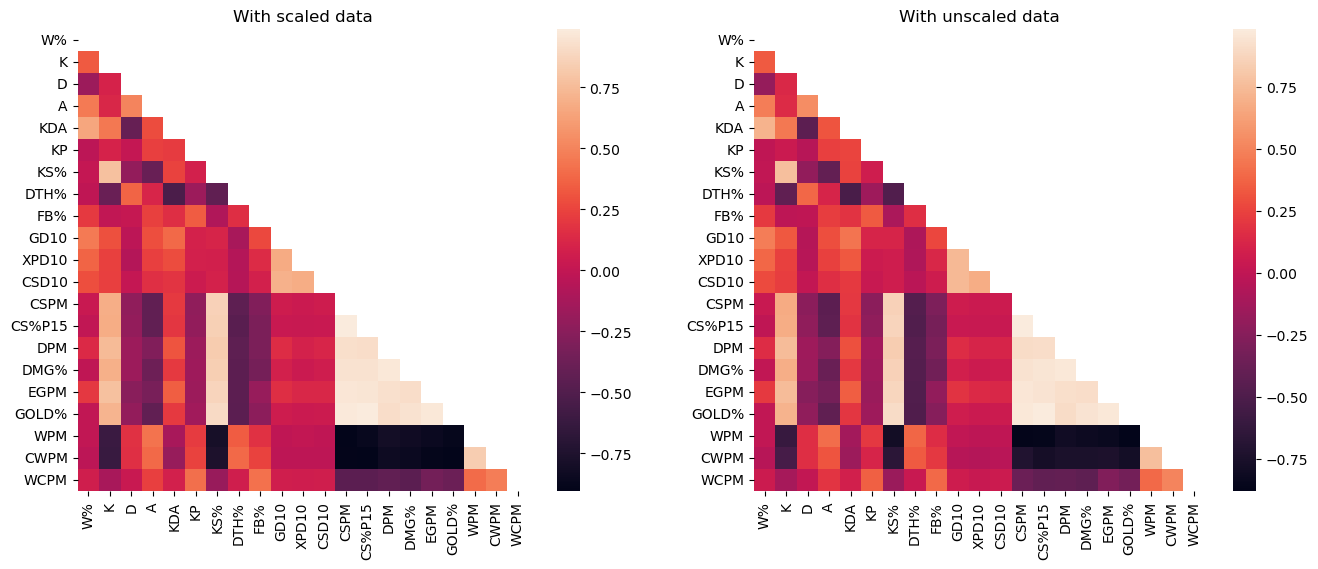

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot the first heatmap in the left subplot
mask = np.triu(np.ones_like(whole_set_vals.corr(), dtype=bool))
sns.heatmap(whole_set_vals.corr(), mask=mask, annot=False, ax=axs[0])
axs[0].set_title('With scaled data')

# Plot the second heatmap in the right subplot
mask = np.triu(np.ones_like(unscaled_set_vals.corr(), dtype=bool))
sns.heatmap(unscaled_set_vals.corr(), mask=mask, annot=False, ax=axs[1])
axs[1].set_title('With unscaled data')

# Show the figure
plt.show()


As we can see, a lot of the features selected are features with insanely high correlation

Eg. CS%P15 and CSPM have a 0.98 corr, and GOLD% and EGPM also have a 0.98 corr

Another aspect (in terms of correlation to MVP points) is that players which play more or win more are naturally inclined to gain more MVP points

We should thus definitely remove Games Played from the list, but Win %age is a contentitious stat to remove. If a player wins more, there is a likelihood that they are playing better, and hence deserve MVP points. Similarly, we can counter by saying that their Team is playing amazing, and they are just being 'carried'. In the end, we decided to remove the Win %age features as well.

(Note: GP was removed earlier due to this very reason)

We see extremely similar corrplots for both scaled and unscaled data

In [16]:
high_corr = whole_set_vals.corr().abs().mask(mask)
to_drop = [column for column in high_corr.columns if any(high_corr[column] > 0.9)]
print(to_drop)
refined_to_drop = ['CS%P15', 'EGPM', 'DPM', 'W%']
#dropping the columns from the dataframe
new_vals = whole_set_vals.drop(columns=refined_to_drop)
new_set = whole_set.drop(columns=refined_to_drop)

unscaled_new_vals = unscaled_set_vals.drop(columns=refined_to_drop)
unscaled_new_set = unscaled_set.drop(columns=refined_to_drop)


['CSPM', 'CS%P15', 'DPM', 'DMG%', 'EGPM', 'GOLD%']


In [17]:
new_role_sets = []
new_role_sets_vals = []

for position in positions:
    new_role_sets.append(new_set[whole_set['Pos'] == position])
    new_role_sets_vals.append(new_vals[whole_set_labels['Pos'] == position])
    # print(position)
    
unscaled_new_role_sets = []
unscaled_new_role_sets_vals = []

for position in positions:
    unscaled_new_role_sets.append(unscaled_new_set[unscaled_set['Pos'] == position])
    unscaled_new_role_sets_vals.append(unscaled_new_vals[unscaled_set_labels['Pos'] == position])

GOLD% is the player's gold as a %age of the team's total gold.

    Players who have higher Earned Gold Per Minute will also have higher GOLD%

    Similarly, higher Creep Score Per Minute also leads to earning higher GOLD

When you have higher GOLD%, you tend to have more items and thus deal more damage

    Therefore DPM and DMG% are also related.

Having higher Creep Share %age post 15 minutes is similarly a highly correlated factor

    With more damage, you tend to clear waves faster

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
role_vifs = []
for role in positions:
    vifs = pd.DataFrame()
    my_set = new_role_sets[positions.index(role)]
    my_set_vals = new_role_sets_vals[positions.index(role)]
    #my_set_labels = role_sets_labels[positions.index(role)]
    vifs['features'] = my_set_vals.columns
    vifs['VIF'] = [variance_inflation_factor(my_set_vals.values, i)
                            for i in range(len(my_set_vals.columns))]
    role_vifs.append(vifs)
    
unscaled_role_vifs = []
for role in positions:
    vifs = pd.DataFrame()
    my_set = unscaled_new_role_sets[positions.index(role)]
    my_set_vals = unscaled_new_role_sets_vals[positions.index(role)]
    #my_set_labels = role_sets_labels[positions.index(role)]
    vifs['features'] = my_set_vals.columns
    vifs['VIF'] = [variance_inflation_factor(my_set_vals.values, i)
                            for i in range(len(my_set_vals.columns))]
    unscaled_role_vifs.append(vifs)

In [19]:
for role in positions:
    vifs = role_vifs[positions.index(role)]
    print("VIFs for Role :", role)
    print(vifs.sort_values(by='VIF', ascending=False).head())
    
    vifs = unscaled_role_vifs[positions.index(role)]
    print("VIFs for Role (unscaled data) :", role)
    print(vifs.sort_values(by='VIF', ascending=False).head())
# shows us that gold%, egpm, etc are highly dependant on other stats.
# eg. gold% is from higher cspm, higher kills, higher gd@10, etc.

VIFs for Role : Middle
   features         VIF
13    GOLD%  541.613463
11     CSPM  514.757116
5       KS%  132.428130
12     DMG%   96.430045
0         K   57.119590
VIFs for Role (unscaled data) : Middle
   features         VIF
4        KP  595.711364
13    GOLD%  552.426029
11     CSPM  471.146641
5       KS%  334.862471
12     DMG%  220.512125
VIFs for Role : Jungle
   features        VIF
13    GOLD%  96.347430
11     CSPM  69.973029
5       KS%  58.276382
0         K  40.073018
2         A  33.018961
VIFs for Role (unscaled data) : Jungle
   features         VIF
13    GOLD%  503.381489
4        KP  357.647750
5       KS%  169.963652
2         A  114.634367
11     CSPM  112.779878
VIFs for Role : ADC
   features         VIF
13    GOLD%  861.810617
11     CSPM  572.079273
5       KS%  200.975885
12     DMG%  151.423867
0         K   77.651876
VIFs for Role (unscaled data) : ADC
   features         VIF
4        KP  691.802969
13    GOLD%  672.864441
5       KS%  499.066465
11     CSP

We now test the hypothesis that any given role is measureably different from another role. We test it visually using PCA and a simple plot, spectral clustering, and with label matching using xgBoost.

A simple PCA 2dim plot can give a good baseline

Spectral clustering is good for identifying clusters in high-deminsional data

xgBoost is capable and fast, and handles complex non-linear relationships, selection of important features, and regularization to prevent overfitting

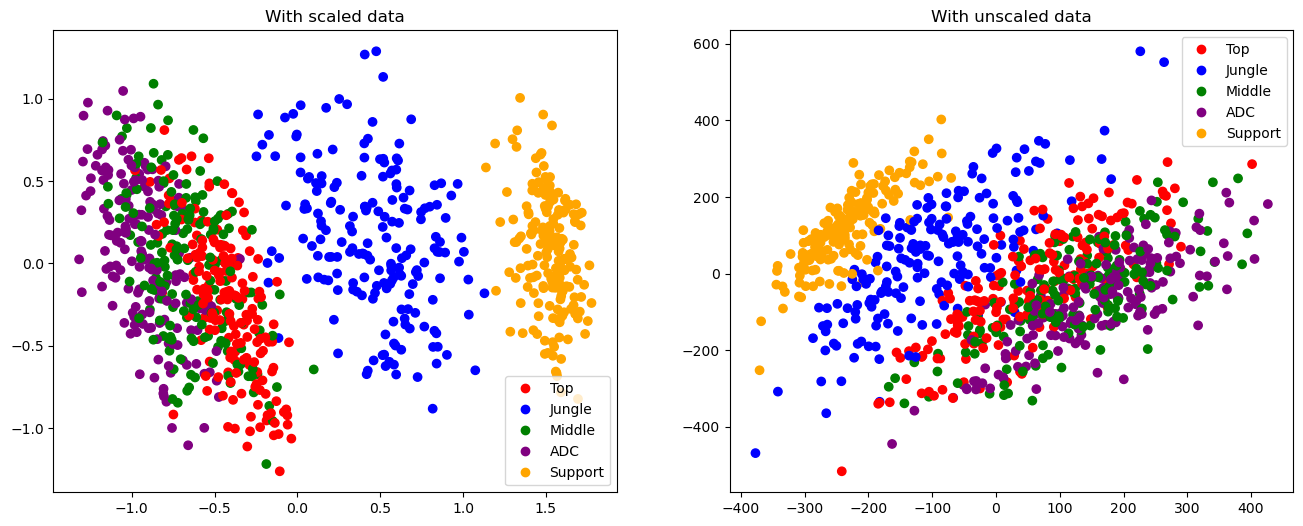

In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(whole_set_vals)

label_color_map = {
    'Top': 'red',
    'Jungle': 'blue',
    'Middle': 'green',
    'ADC': 'purple',
    'Support': 'orange'
}

colors = np.array([label_color_map[label] for label in whole_set_labels['Pos']])


fig, axs = plt.subplots(1, 2, figsize=(16, 6))
scatter = axs[0].scatter(X_pca[:, 0], X_pca[:, 1], c=colors, 
                     label=whole_set_labels['Pos'])
axs[0].set_title('With scaled data')

# Add labels to the points
#for i, txt in enumerate(larger_dataset_labels['Pos']):
#    ax.annotate(txt, (X_pca[i, 0], X_pca[i, 1]))

legend_elements = [plt.Line2D([0], [0], marker='o', color=color, 
                              label=label, linestyle='') for label, color in label_color_map.items()]
axs[0].legend(handles=legend_elements, loc='best')


# Plot the second scatter plot in the right subplot
unscaled_X_pca = pca.fit_transform(unscaled_set_vals)
scatter = axs[1].scatter(unscaled_X_pca[:, 0], unscaled_X_pca[:, 1], c=colors, label=whole_set_labels['Pos'])
axs[1].set_title('With unscaled data')
legend_elements = [plt.Line2D([0], [0], marker='o', color=color, label=label, linestyle='') for label, color in label_color_map.items()]
axs[1].legend(handles=legend_elements, loc='best')

plt.show()

We can visually see with the 2dim PCA plot, that the Support and Jungle role are clearly different from the Mid, Top, and ADC roles for scaled data

For unscaled data, the separation along PCA axes is a bit less clear

In [21]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
pos_encoded = label_encoder.fit_transform(whole_set_labels['Pos'])

# Use the earlier PCA
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, pos_encoded, test_size=0.2, random_state=42)

# Train the XGBoost classifier on PCA-transformed data
clf_pca = xgb.XGBClassifier(objective='multi:softmax', num_class=5, max_depth=5, learning_rate=0.1, n_estimators=100, random_state=42)
clf_pca.fit(X_train_pca, y_train_pca)

# Predict on the test set and calculate accuracy
y_pred_pca = clf_pca.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test_pca, y_pred_pca)
print('Accuracy with PCA: %.2f%%' % (accuracy_pca * 100.0))

# Train the XGBoost classifier on raw data
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(new_vals, pos_encoded, test_size=0.2, random_state=42)

clf_raw = xgb.XGBClassifier(objective='multi:softmax', num_class=5, max_depth=5, learning_rate=0.1, n_estimators=100, random_state=42)
clf_raw.fit(X_train_raw, y_train_raw)

# Predict on the test set and calculate accuracy
y_pred_raw = clf_raw.predict(X_test_raw)
accuracy_raw = accuracy_score(y_test_raw, y_pred_raw)
print('Accuracy without PCA (raw data): %.2f%%' % (accuracy_raw * 100.0))

# Train the XGBoost classifier on unscaled raw data
unscaled_X_train_raw, unscaled_X_test_raw, unscaled_y_train_raw, unscaled_y_test_raw = train_test_split(unscaled_new_vals, pos_encoded, test_size=0.2, random_state=42)

clf_unscaled_raw = xgb.XGBClassifier(objective='multi:softmax', num_class=5, max_depth=5, learning_rate=0.1, n_estimators=100, random_state=42)
clf_unscaled_raw.fit(unscaled_X_train_raw, unscaled_y_train_raw)

# Predict on the test set and calculate accuracy
y_pred_unscaled_raw = clf_unscaled_raw.predict(unscaled_X_test_raw)
accuracy_unscaled_raw = accuracy_score(unscaled_y_test_raw, y_pred_unscaled_raw)
print('Accuracy without PCA (unscaled raw data): %.2f%%' % (accuracy_unscaled_raw * 100.0))


Accuracy with PCA: 73.48%
Accuracy without PCA (raw data): 89.50%
Accuracy without PCA (unscaled raw data): 88.40%


xgBoost provides a ~90% accuracy on the given data in classifying players into their respective positions based on data. Using PCA cuts it down to ~75%.

This seems to strongly suggest that there is a clear cut difference between various roles

In [22]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM

# One-hot encode y_train
y_train_pca_one_hot = to_categorical(y_train_pca) 
y_train_one_hot = to_categorical(y_train_raw)
unscaled_y_train_one_hot = to_categorical(unscaled_y_train_raw)

# Define model architecture
model_pca = Sequential()
model_pca.add(LSTM(32, input_shape=(X_train_pca.shape[1], 1)))
model_pca.add(Dense(5, activation='softmax'))

model = Sequential()
model.add(LSTM(32, input_shape=(X_train_raw.shape[1], 1)))
model.add(Dense(5, activation='softmax'))

# Compile model
model_pca.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model (with PCA)
model_pca.fit(X_train_pca, y_train_pca_one_hot, batch_size=32, epochs=50, verbose=0)

# Evaluate model (with PCA)
loss, accuracy = model_pca.evaluate(X_test_pca, to_categorical(y_test_pca), verbose=0)
print('Test loss (with PCA):', loss)
print('Test accuracy (with PCA):', accuracy)

# Train model (without PCA)
model.fit(X_train_raw, y_train_one_hot, batch_size=32, epochs=50, verbose=0)

# Evaluate model (without PCA)
loss, accuracy = model.evaluate(X_test_raw, to_categorical(y_test_raw), verbose=0)
print('Test loss (without PCA):', loss)
print('Test accuracy (without PCA):', accuracy)

# Train model (unscaled)
model.fit(unscaled_X_train_raw, unscaled_y_train_one_hot, batch_size=32, epochs=50, verbose=0)

# Evaluate model (unscaled)
loss, accuracy = model.evaluate(unscaled_X_test_raw, to_categorical(unscaled_y_test_raw), verbose=0)
print('Test loss (for unscaled):', loss)
print('Test accuracy (for unscaled):', accuracy)


Test loss (with PCA): 0.4921717345714569
Test accuracy (with PCA): 0.7679557800292969
Test loss (without PCA): 0.4950654208660126
Test accuracy (without PCA): 0.7679557800292969
Test loss (for unscaled): 0.4640832841396332
Test accuracy (for unscaled): 0.7790055274963379


Around 75~ accuracy, good indication overall to proceed with role-separation for ranking

In [23]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

estimator = LinearRegression()

# Create an instance of Recursive Feature Elimination (RFE) 
# with estimator as the linear regression model, and select top 10 features
rfe = RFE(estimator=estimator, n_features_to_select=10, step=1)

# Fit the RFE instance to the scaled data 'new_vals' to select top 10 features
rfe.fit(new_vals, whole_set_labels['MVP'])

print("for scaled data :\n", new_vals.columns[rfe.support_])

# Fit the RFE instance to the unscaled data 'unscaled_new_vals' to select top 10 features
rfe.fit(unscaled_new_vals, whole_set_labels['MVP'])

print("for unscaled data :\n", unscaled_new_vals.columns[rfe.support_])

for scaled data :
 Index(['K', 'A', 'KDA', 'DTH%', 'FB%', 'GD10', 'CSPM', 'DMG%', 'GOLD%', 'WPM'], dtype='object')
for unscaled data :
 Index(['KDA', 'KS%', 'DTH%', 'CSD10', 'CSPM', 'DMG%', 'GOLD%', 'WPM', 'CWPM',
       'WCPM'],
      dtype='object')


RFE (Recursive Feature Elimination) is a feature selection algorithm that aims to reduce the number of input features for a machine learning model by recursively removing the least important features. It works by training a model on the full set of features and ranking them based on their importance. Then, the least important feature is removed and the model is retrained. This process is repeated until a desired number of features is reached. RFE is useful when working with high-dimensional datasets, as it helps to identify the most relevant features for a particular task, which can improve model performance and reduce overfitting.

Overall, these results suggest that factors such as kills, assists, deaths, damage dealt, gold earned, creep score, and various types of performance ratios are important indicators for predicting a player's MVP points. The exact set of important features can vary depending on whether the data is scaled or unscaled, and which specific statistics are included in the analysis.

In [24]:
common_features = None
common_three = None
common_four = None

relevant_cols = []
unscaled_relevant_cols = []

for role in positions:
    # better to use a dictionary, but not really important
    my_set_labels = role_sets_labels[positions.index(role)]
    my_set_vals = new_role_sets_vals[positions.index(role)]
    rfe = RFE(estimator=estimator, n_features_to_select=10, step=1)
    rfe.fit(my_set_vals, my_set_labels['MVP'])
    
    print("for role :", role)
    print(my_set_vals.columns[rfe.support_], "\n")
    relevant_cols.append(my_set_vals.columns[rfe.support_])
    
    if common_features is None:
        common_features = set(my_set_vals.columns[rfe.support_])
    else:
        common_features = common_features.intersection(set(my_set_vals.columns[rfe.support_]))
    if role in ['ADC', 'Mid', 'Top']:
        if common_three is None:
            common_three = set(my_set_vals.columns[rfe.support_])
        else:
            common_three = common_three.intersection(set(my_set_vals.columns[rfe.support_]))
    if role in ['ADC', 'Mid', 'Top', 'Jungle']:
        if common_four is None:
            common_four = set(my_set_vals.columns[rfe.support_])
        else:
            common_four = common_four.intersection(set(my_set_vals.columns[rfe.support_]))
        
print("Common features across all roles:", common_features)
print("Common across ADC, Mid, Top", common_three)
print("Common across above three and Jungle", common_four)

for role : Middle
Index(['K', 'D', 'A', 'KDA', 'KS%', 'DTH%', 'GD10', 'CSPM', 'DMG%', 'WPM'], dtype='object') 

for role : Jungle
Index(['K', 'A', 'KDA', 'KP', 'KS%', 'DTH%', 'GD10', 'CSPM', 'WPM', 'WCPM'], dtype='object') 

for role : ADC
Index(['K', 'D', 'A', 'KP', 'CSD10', 'DMG%', 'GOLD%', 'WPM', 'CWPM', 'WCPM'], dtype='object') 

for role : Top
Index(['K', 'A', 'KDA', 'KP', 'KS%', 'GD10', 'CSPM', 'DMG%', 'GOLD%', 'WPM'], dtype='object') 

for role : Support
Index(['K', 'D', 'A', 'KDA', 'KS%', 'CSPM', 'DMG%', 'GOLD%', 'WPM', 'CWPM'], dtype='object') 

Common features across all roles: {'K', 'WPM', 'A'}
Common across ADC, Mid, Top {'KP', 'GOLD%', 'A', 'DMG%', 'K', 'WPM'}
Common across above three and Jungle {'KP', 'WPM', 'A', 'K'}


In [25]:
for role in positions:
    my_set_labels = unscaled_role_sets_labels[positions.index(role)]
    my_set_vals = unscaled_new_role_sets_vals[positions.index(role)]
    rfe = RFE(estimator=estimator, n_features_to_select=10, step=1)
    rfe.fit(my_set_vals, my_set_labels['MVP'])
    
    print("for role (now unscaled) :", role)
    print(my_set_vals.columns[rfe.support_], "\n")
    unscaled_relevant_cols.append(my_set_vals.columns[rfe.support_])
    
    if common_features is None:
        common_features = set(my_set_vals.columns[rfe.support_])
    else:
        common_features = common_features.intersection(set(my_set_vals.columns[rfe.support_]))
    if role in ['ADC', 'Mid', 'Top']:
        if common_three is None:
            common_three = set(my_set_vals.columns[rfe.support_])
        else:
            common_three = common_three.intersection(set(my_set_vals.columns[rfe.support_]))
    if role in ['ADC', 'Mid', 'Top', 'Jungle']:
        if common_four is None:
            common_four = set(my_set_vals.columns[rfe.support_])
        else:
            common_four = common_four.intersection(set(my_set_vals.columns[rfe.support_]))
        
print("Common features across all roles:", common_features)
print("Common across ADC, Mid, Top", common_three)
print("Common across above three and Jungle", common_four)

for role (now unscaled) : Middle
Index(['K', 'KDA', 'KS%', 'DTH%', 'CSD10', 'CSPM', 'GOLD%', 'WPM', 'CWPM',
       'WCPM'],
      dtype='object') 

for role (now unscaled) : Jungle
Index(['K', 'KDA', 'KP', 'KS%', 'DTH%', 'CSPM', 'GOLD%', 'WPM', 'CWPM',
       'WCPM'],
      dtype='object') 

for role (now unscaled) : ADC
Index(['KDA', 'KP', 'DTH%', 'CSD10', 'CSPM', 'DMG%', 'GOLD%', 'WPM', 'CWPM',
       'WCPM'],
      dtype='object') 

for role (now unscaled) : Top
Index(['KDA', 'KP', 'DTH%', 'FB%', 'CSD10', 'DMG%', 'GOLD%', 'WPM', 'CWPM',
       'WCPM'],
      dtype='object') 

for role (now unscaled) : Support
Index(['K', 'KDA', 'KP', 'KS%', 'DTH%', 'CSD10', 'CSPM', 'WPM', 'CWPM',
       'WCPM'],
      dtype='object') 

Common features across all roles: {'WPM'}
Common across ADC, Mid, Top {'KP', 'GOLD%', 'WPM', 'DMG%'}
Common across above three and Jungle {'KP', 'WPM'}


Now with this information, lets develop a ranking system for the players

    First, we have to decide what we want to rank them based on:

    There are two options, either the MVP points, or their percentile performance within their role

    We will use both to rank, then combine

For the features used in ranking, we will use the features selected by RFE above, for their respective role

In [26]:
from keras.layers import Dropout, Conv1D, MaxPooling1D, Flatten, SimpleRNN

# only to define shape
X_train, X_test, y_train, y_test = train_test_split(new_role_sets_vals[0][relevant_cols[0]], role_sets_labels[0]['MVP'], test_size=0.2, random_state=42)

basic_lstm = Sequential()
basic_lstm.add(LSTM(32, input_shape=(X_train.shape[1], 1)))
basic_lstm.add(Dense(1, activation='linear'))
basic_lstm.compile(loss='mean_squared_error', optimizer='adam')

bsc_lstm_sgm = Sequential()
bsc_lstm_sgm.add(LSTM(32, input_shape=(X_train.shape[1], 1)))
bsc_lstm_sgm.add(Dense(1, activation='sigmoid'))
bsc_lstm_sgm.compile(loss='mean_squared_error', optimizer='adam')

stacked_dropout = Sequential()
stacked_dropout.add(LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], 1)))
stacked_dropout.add(Dropout(0.2))
stacked_dropout.add(LSTM(16))
stacked_dropout.add(Dense(1, activation='linear'))
stacked_dropout.compile(loss='mean_squared_error', optimizer='adam')

convolution = Sequential()
convolution.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
convolution.add(MaxPooling1D(pool_size=2))
convolution.add(Flatten())
convolution.add(Dense(1, activation='linear'))
convolution.compile(loss='mean_squared_error', optimizer='adam')

rnn = Sequential()
rnn.add(SimpleRNN(32, input_shape=(X_train.shape[1], 1)))
rnn.add(Dense(1, activation='linear'))
rnn.compile(loss='mean_squared_error', optimizer='adam')

Stacked LSTM : 

The above model uses two LSTM layers and a Dense layer. The first LSTM layer has 32 units and 
        returns sequences, while the second LSTM layer has 16 units. The output layer is a Dense layer 
        with a single output and a linear activation function.
        The use of two LSTM layers allows the model to learn and extract features from the time series 
        data in a more complex and sophisticated way. The return_sequences=True parameter for the first 
        LSTM layer allows it to pass the sequence of output values from each time step to the next 
        LSTM layer for further processing. This is important for capturing the sequential dependencies 
        in the data. The second LSTM layer then takes the final output of the previous LSTM layer and 
        further reduces the dimensionality of the features extracted.
        Including a Dropout layer with a rate of 0.2 just before the final Dense layer can help to 
        prevent overfitting. Dropout randomly sets a fraction of the input units to 0 at each update 
        during training time, which can force the network to learn more robust features and reduce the 
        impact of individual neurons. By adding a Dropout layer with a rate of 0.2, we are 
        essentially randomly setting 20% of the input units to 0, which can help to prevent 
        over-reliance on specific features and reduce the risk of overfitting to the training data.
        The final output layer is a Dense layer with a single output and a linear activation function, 
        which is suitable for regression tasks. The linear activation function allows the model to 
        output a continuous range of values, which is desirable for predicting continuous target variables.

Convolution : 

The first variation uses a 1D CNN layer with 32 filters, a kernel size of 3, and a stride of 1. 
        The output from the CNN layer is flattened and passed through a dense layer with 16 units and 
        a ReLU activation function. The final output layer is a dense layer with a single unit and 
        a linear activation function. This architecture is expected to perform well because the 
        CNN layer can learn local patterns in the input sequence, while the dense layers can capture 
        more complex relationships between the features. The ReLU activation function helps 
        prevent vanishing gradients during training, and the linear activation function in the 
        output layer allows for the prediction of continuous values.

In [47]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from keras.models import load_model
from joblib import dump, load

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]))


def fit_and_print(args, model, isNotNeural):
    # Train model
    X_train = args[0]
    y_train = args[1]
    X_test = args[2]
    y_test = args[3]
    
    if isNotNeural:
        model.fit(X_train, y_train)
        
        # Calculate predictions, MAPE, r2
        y_pred = model.predict(X_test)
        
        # Evaluate model
        mape = mean_absolute_percentage_error(y_test, y_pred)
        r2 = r2_score(y_true=y_test, y_pred=y_pred)
        loss = mean_squared_error(y_true=y_test, y_pred=y_pred)

        return loss, mape, y_pred, r2
    else:
        model.fit(X_train, y_train, batch_size=32, epochs=50, verbose=0)

        # Evaluate model
        loss = round(model.evaluate(X_test, y_test, verbose=0), 2)
        
        # Calculate predictions and MAPE
        y_pred = model.predict(X_test, verbose=0)
        mape = round(mean_absolute_percentage_error(y_test, y_pred), 2)
        r2 = r2_score(y_true=y_test, y_pred=y_pred)
        
        return loss, mape, y_pred, r2
    # df = pd.DataFrame(data={'prediction': y_pred.ravel(), 'actual': y_test.ravel()})
    # print(df.head())
    
def make_double_plot(plotting_df, text, label_color_map=label_color_map):
    # plot results
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    for role, color in label_color_map.items():
        role_data = plotting_df[plotting_df['Role'] == role]
        axs[0].scatter(x=role_data['Actual'], y=role_data['Predicted'], c=color, label=role, alpha=0.5)
        residuals = role_data['Predicted'] - role_data['Actual']
        axs[1].hist(residuals, bins=20, color=color, alpha=0.5, label=role)
        # axs[1] = sns.displot(residuals, kde=True)
    axs[0].plot([0, 1], [0, 1], transform=axs[0].transAxes, ls='--', c='gray', linewidth=3)
    axs[0].legend()
    axs[0].set_xlim([0, 1])
    axs[0].set_ylim([0, 1])
    axs[0].set_xlabel('Actual')
    axs[0].set_ylabel('Predicted')
    titlestr = "Actual vs Predicted by Role for " + text
    axs[0].set_title(titlestr)
    axs[1].legend()
    axs[1].set_xlim([-1, 1])
    axs[1].set_xlabel('Residuals')
    axs[1].set_ylabel('Frequency')
    axs[1].set_title('Residual Plot')
    plt.show()

def models_evaluations(args, model, text, isNotNeural=0, model_files=models_directory):
    
    values_list_by_roles, VIF_selected_features, labels_list_by_roles, positions = args[0], args[1], args[2], args[3]
    
    plotting_df = pd.DataFrame(columns=['Role', 'Actual', 'Predicted'])
    results = []
    role_models = {}
    os.chdir(model_files)
    
    print("Metrics for", text)
    for i in range(0, 5):
        role = positions[i]

        X_train, X_test, y_train, y_test = train_test_split(values_list_by_roles[i][VIF_selected_features[i]], 
                                                            labels_list_by_roles[i]['MVP'], 
                                                            test_size=0.2, random_state=42)
        # mini test for predicting when we remove entries with under 0.2 POG points
        # yes, we understand that giving high predictions for lower pog players could 
        # indicate that they are underrated
        
        X_train = X_train[y_train > 0.2]
        y_train = y_train[y_train > 0.2]
        X_test = X_test[y_test > 0.2]
        y_test = y_test[y_test > 0.2]
        
        # after running experiment, results obtained show that
        # INSANE performance gain is obtained
        # seriously considering whether to sacrifice < 0.2
        # to gain huge improvements
        # goes from 100~90% in neural to 25-40%
        # goes from 60-70% in non-neural to 30-40%
        
        # second mini test, above but reverse
        
        # X_train = X_train[y_train <= 0.2]
        # y_train = y_train[y_train <= 0.2]
        # X_test = X_test[y_test <= 0.2]
        # y_test = y_test[y_test <= 0.2]
        
        # results show that kinda not fine cause too low results
        # yeah mape is around 0.5, much better than 1.0 or 0.7
        # but not really valid imo, sample size waaay too small
        
        args_1 = [X_train, y_train, X_test, y_test]
        
        loss, mape, y_pred, r2 = fit_and_print(args_1, model, isNotNeural)
        results.append([role, loss, mape, r2])
        if isNotNeural:
            saved_model_name = text.replace(" ","_") + "_" +role+".joblib"
            dump(model, saved_model_name)
        
        else:        
            saved_model_name = text.replace(" ", "_") + "_" + role +".keras"
            model.save(saved_model_name)
        role_models[role] = saved_model_name
        
        actual = y_test.values
        predicted = y_pred.ravel()
        plotting_df = plotting_df.append(pd.DataFrame({'Role': role, 
                                                       'Actual': actual,
                                                       'Predicted': predicted}), ignore_index=True)
                
    df = pd.DataFrame(results, columns=['Role', 'Loss', 'MAPE', 'R2 Score'])
    print(df)

    make_double_plot(plotting_df=plotting_df, text=text)
    
    return role_models
    

In [48]:
models_dict = {"Basic LSTM" : basic_lstm, 
               "Basic LSTM with sigmoid acv fn" : bsc_lstm_sgm, 
               "Stacked LSTM with dropout" : stacked_dropout, 
               "Convolution model" : convolution, 
               "RNN Model" : rnn}

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

XGreg = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=7)
RFreg = RandomForestRegressor(n_estimators=100, max_depth=7)
SVreg = SVR(kernel='rbf', C=1e3, gamma=0.1)
KNreg = KNeighborsRegressor(n_neighbors=5)

kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
GPreg = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

normal_models = {"XGB Regressor" : XGreg, 
                 "Random Forest Regressor" : RFreg, 
                 "Support Vector Regression" : SVreg, 
                 "KNN Regression" : KNreg, 
                 "Gausian Process Kernel" : GPreg}

scaled_input_args = [new_role_sets_vals, relevant_cols, role_sets_labels, positions]
unscaled_input_args = [unscaled_new_role_sets_vals, unscaled_relevant_cols, unscaled_role_sets_labels, positions]



Metrics for Basic LSTM
      Role  Loss  MAPE  R2 Score
0   Middle  0.03  0.39  0.310321
1   Jungle  0.01  0.41  0.404139
2      ADC  0.06  0.26 -0.494002
3      Top  0.04  0.36  0.166017
4  Support  0.02  0.31  0.084251


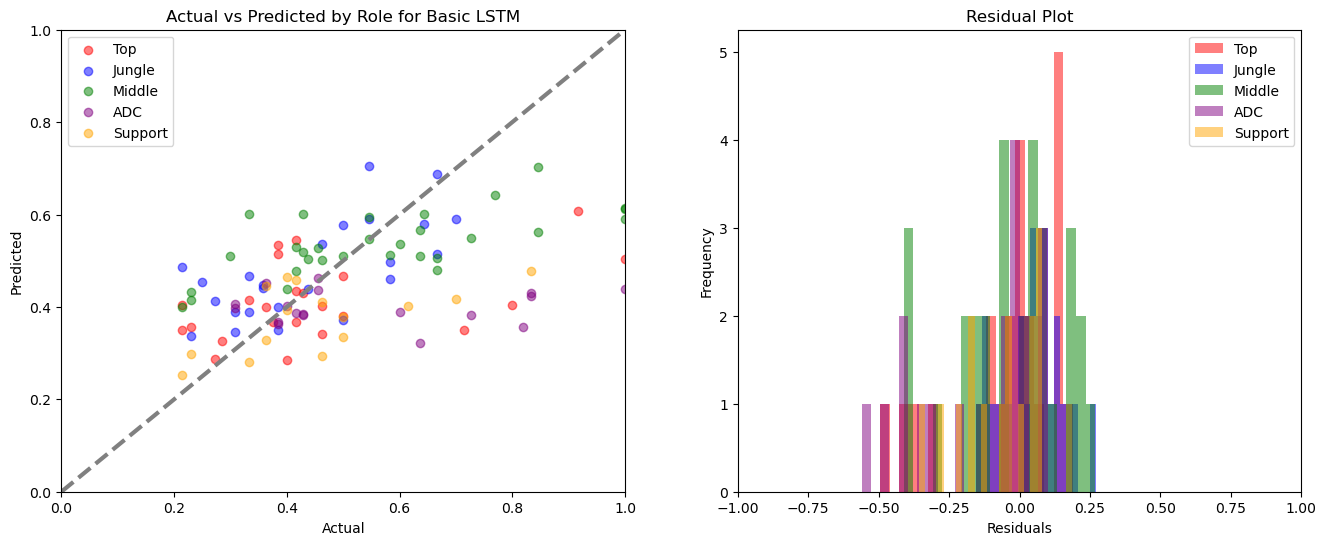

Metrics for Basic LSTM with sigmoid acv fn
      Role  Loss  MAPE  R2 Score
0   Middle  0.03  0.45  0.351286
1   Jungle  0.01  0.44  0.349461
2      ADC  0.05  0.28 -0.108515
3      Top  0.03  0.37  0.212141
4  Support  0.03  0.30 -0.023999


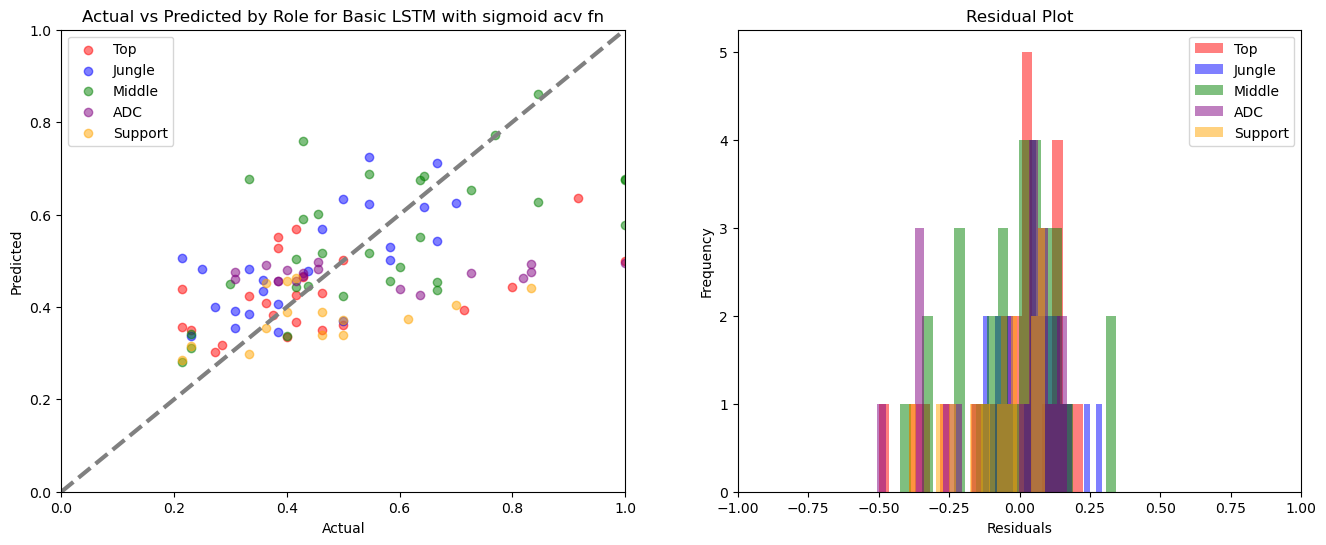

Metrics for Stacked LSTM with dropout
      Role  Loss  MAPE  R2 Score
0   Middle  0.03  0.43  0.428243
1   Jungle  0.01  0.42  0.373274
2      ADC  0.06  0.26 -0.303323
3      Top  0.03  0.37  0.195866
4  Support  0.02  0.31  0.042013


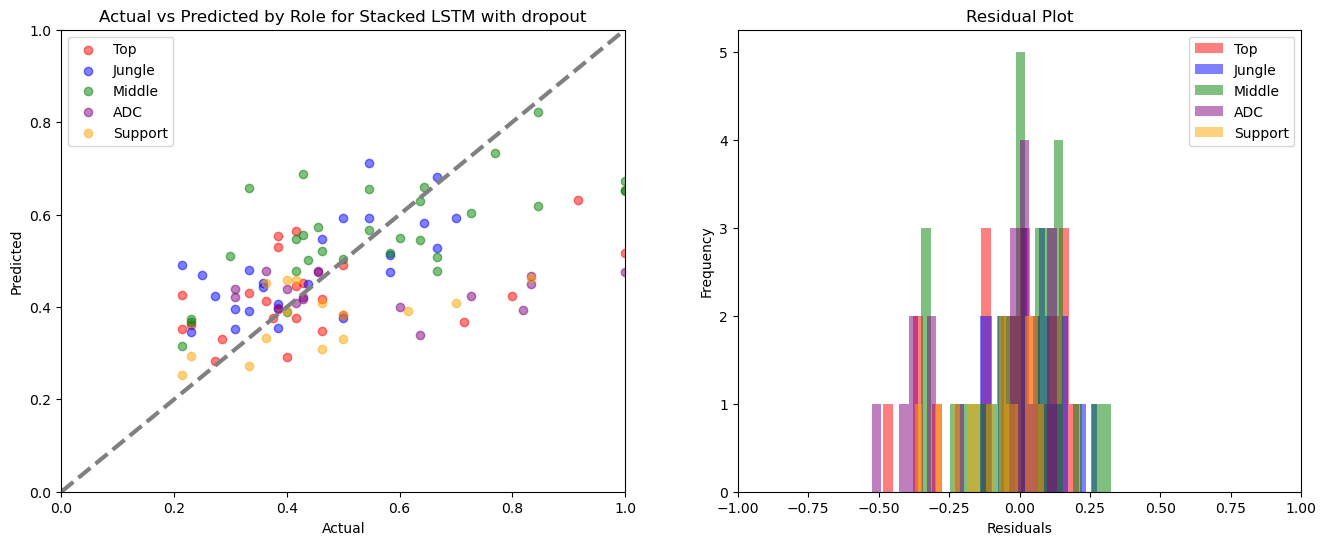

Metrics for Convolution model
      Role  Loss  MAPE  R2 Score
0   Middle  0.03  0.42  0.415726
1   Jungle  0.01  0.42  0.342590
2      ADC  0.05  0.28 -0.124553
3      Top  0.03  0.37  0.179094
4  Support  0.02  0.32  0.078069


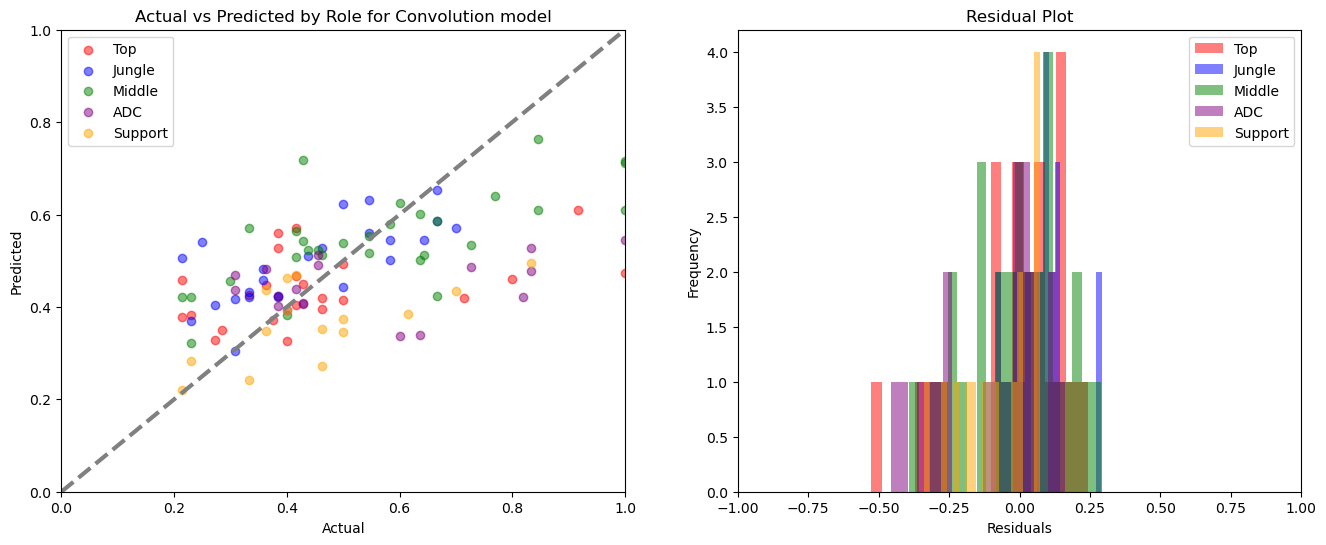

Metrics for RNN Model
      Role  Loss  MAPE  R2 Score
0   Middle  0.03  0.47  0.409911
1   Jungle  0.01  0.42  0.340796
2      ADC  0.05  0.29 -0.052339
3      Top  0.03  0.42  0.217136
4  Support  0.03  0.30 -0.116719


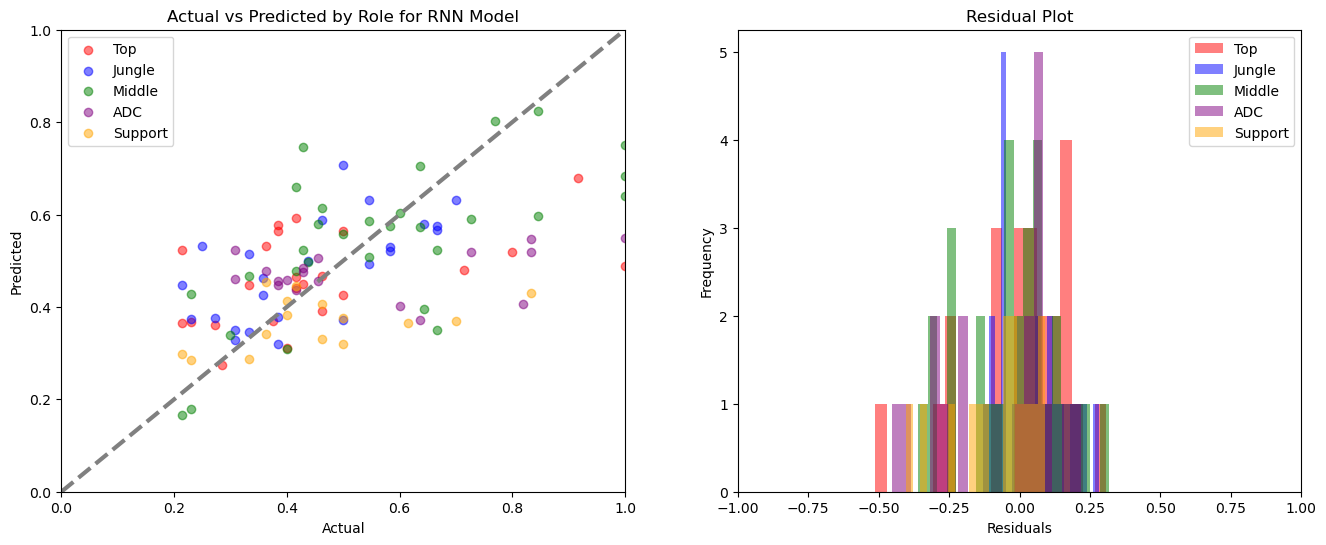

In [29]:
nn_scaled = {}
for key, value in models_dict.items():
    nn_scaled[key] = models_evaluations(scaled_input_args, value, key)

As we can see, the Mean Abs %age errors are about 100 for ADC, Mid, Supp, and around 90 for Top, Jgl

This shows that our neural models are having absolutely terrible showings in predicting MVP points with the average difference between the prediction and true value

Metrics for Basic LSTM
      Role  Loss  MAPE  R2 Score
0   Middle  0.05  0.37  0.036148
1   Jungle  0.02  0.37 -0.036632
2      ADC  0.06  0.26 -0.358253
3      Top  0.04  0.44 -0.038311
4  Support  0.03  0.28 -0.250192


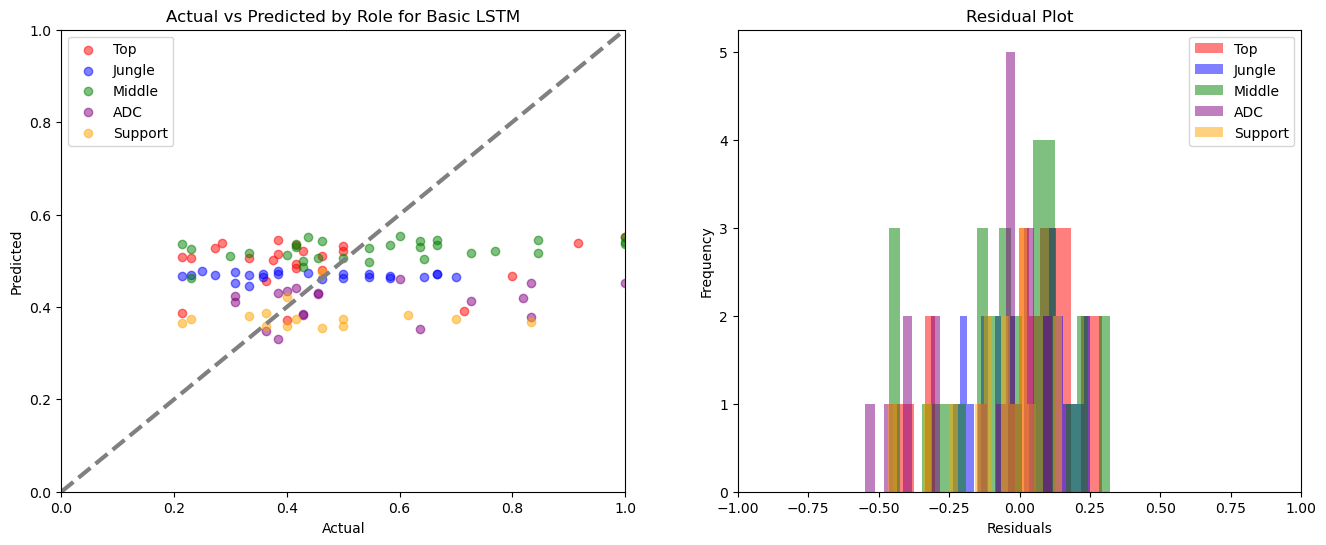

Metrics for Basic LSTM with sigmoid acv fn
      Role  Loss  MAPE  R2 Score
0   Middle  0.05  0.37  0.039822
1   Jungle  0.02  0.37  0.173617
2      ADC  0.06  0.27 -0.406831
3      Top  0.04  0.44 -0.041066
4  Support  0.03  0.27 -0.266240


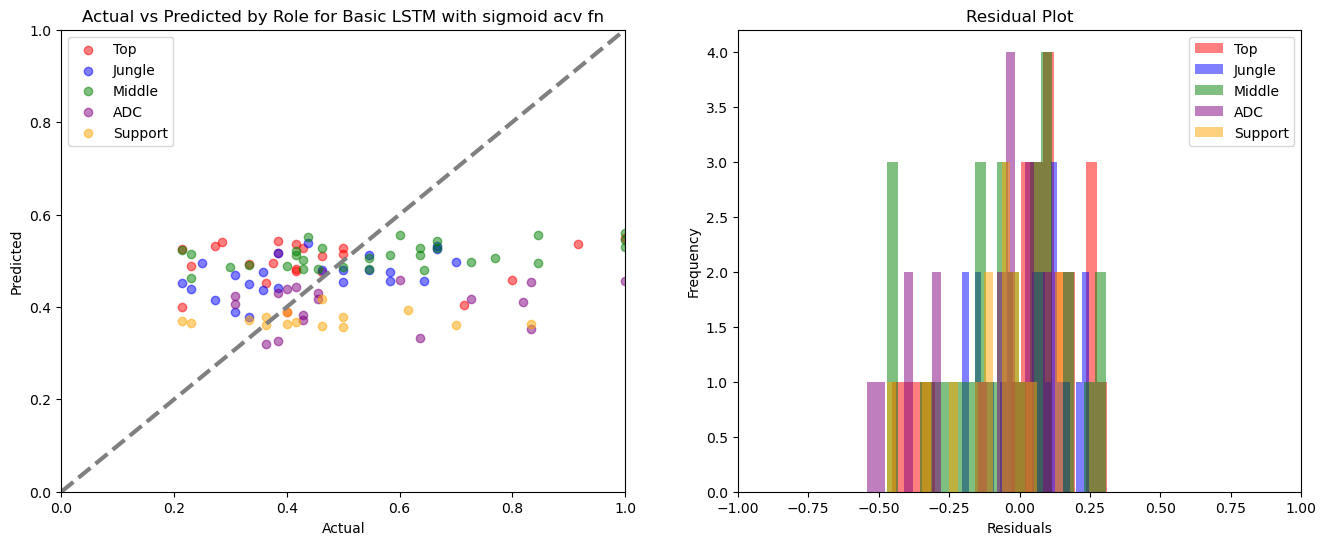

Metrics for Stacked LSTM with dropout
      Role  Loss  MAPE  R2 Score
0   Middle  0.04  0.37  0.097696
1   Jungle  0.02  0.39  0.222118
2      ADC  0.06  0.27 -0.474250
3      Top  0.05  0.46 -0.063737
4  Support  0.03  0.28 -0.211542


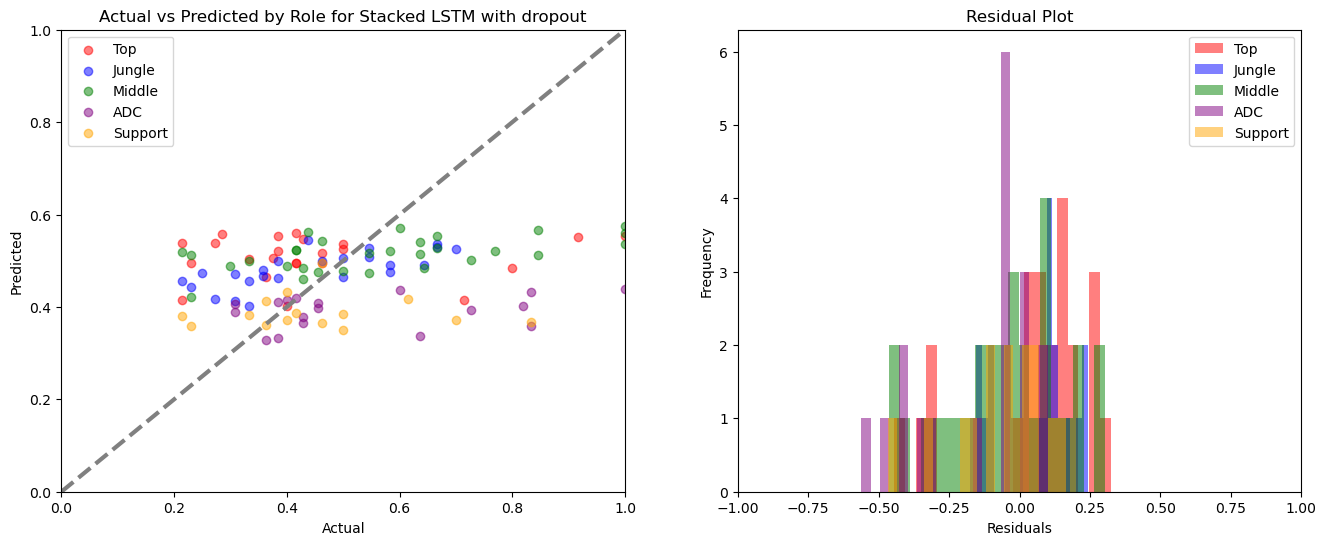

Metrics for Convolution model
      Role  Loss  MAPE  R2 Score
0   Middle  0.37  1.22 -6.699818
1   Jungle  0.02  0.49 -0.122492
2      ADC  0.07  0.38 -0.536722
3      Top  0.05  0.47 -0.213682
4  Support  0.08  0.51 -2.080659


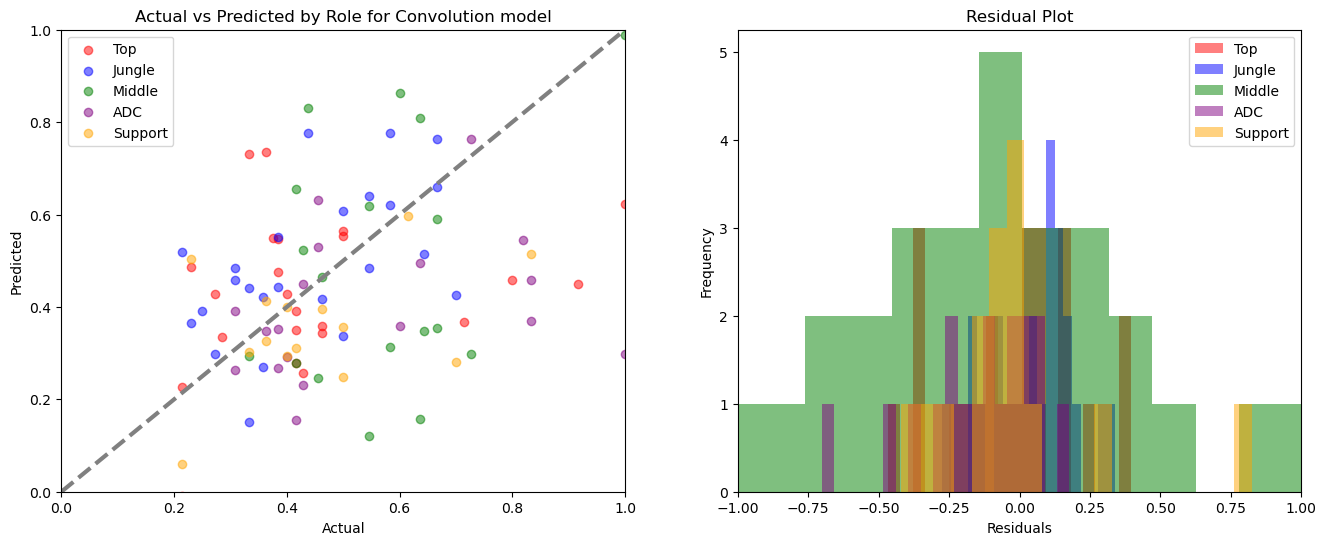

Metrics for RNN Model
      Role  Loss  MAPE  R2 Score
0   Middle  0.04  0.36  0.096725
1   Jungle  0.02  0.37  0.092156
2      ADC  0.07  0.29 -0.739494
3      Top  0.05  0.44 -0.106825
4  Support  0.03  0.32 -0.211961


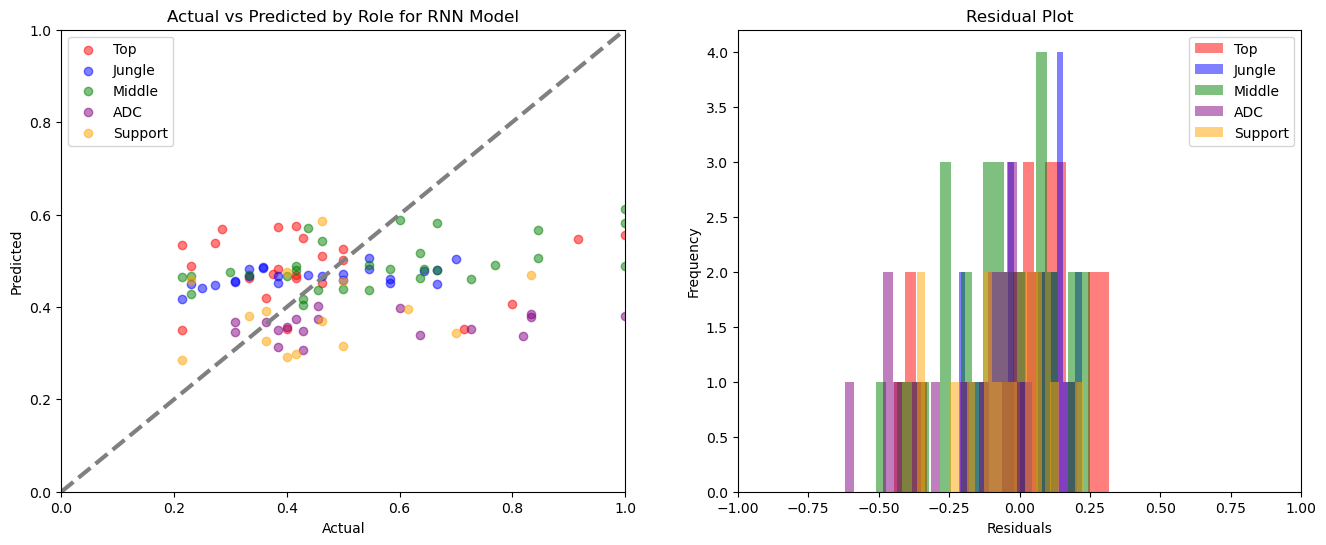

In [30]:
nn_unscaled = {}
for key, value in models_dict.items():
    nn_unscaled[key] = models_evaluations(unscaled_input_args, value, key)


Lets test with non-neural network based machine learning algorithms

Metrics for XGB Regressor
      Role      Loss      MAPE  R2 Score
0   Middle  0.018248  0.226574  0.623810
1   Jungle  0.022511  0.316105 -0.041100
2      ADC  0.041687  0.281776  0.026011
3      Top  0.031914  0.359480  0.248055
4  Support  0.034484  0.367793 -0.360504


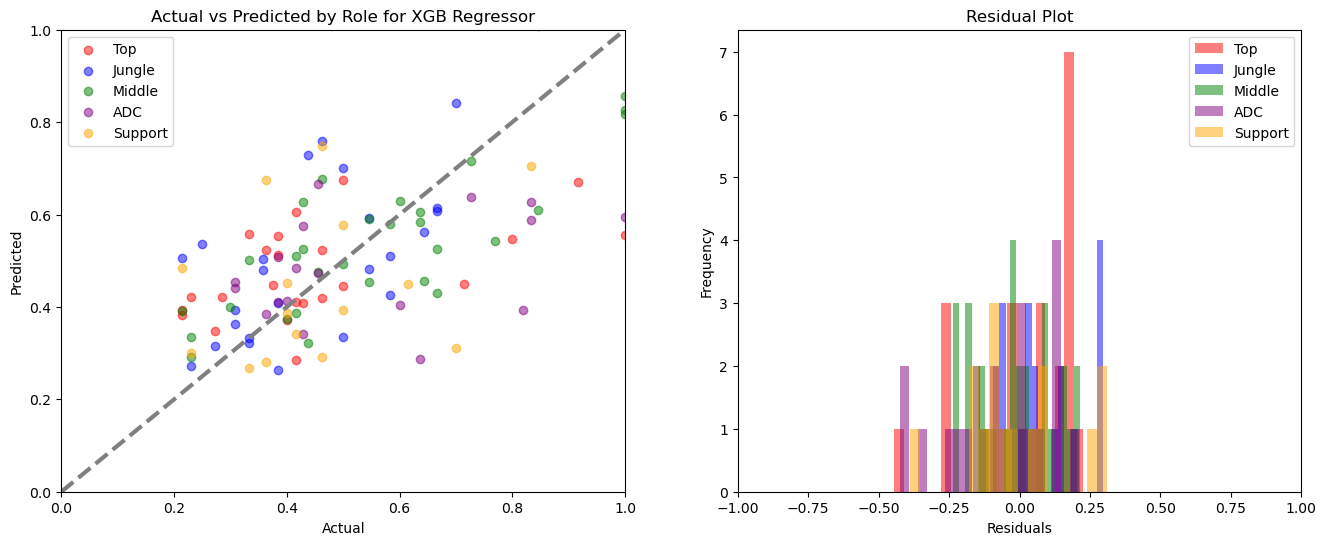

Metrics for Random Forest Regressor
      Role      Loss      MAPE  R2 Score
0   Middle  0.021040  0.238336  0.566253
1   Jungle  0.013968  0.269913  0.353993
2      ADC  0.042457  0.302609  0.008017
3      Top  0.030451  0.334516  0.282528
4  Support  0.018235  0.281402  0.280560


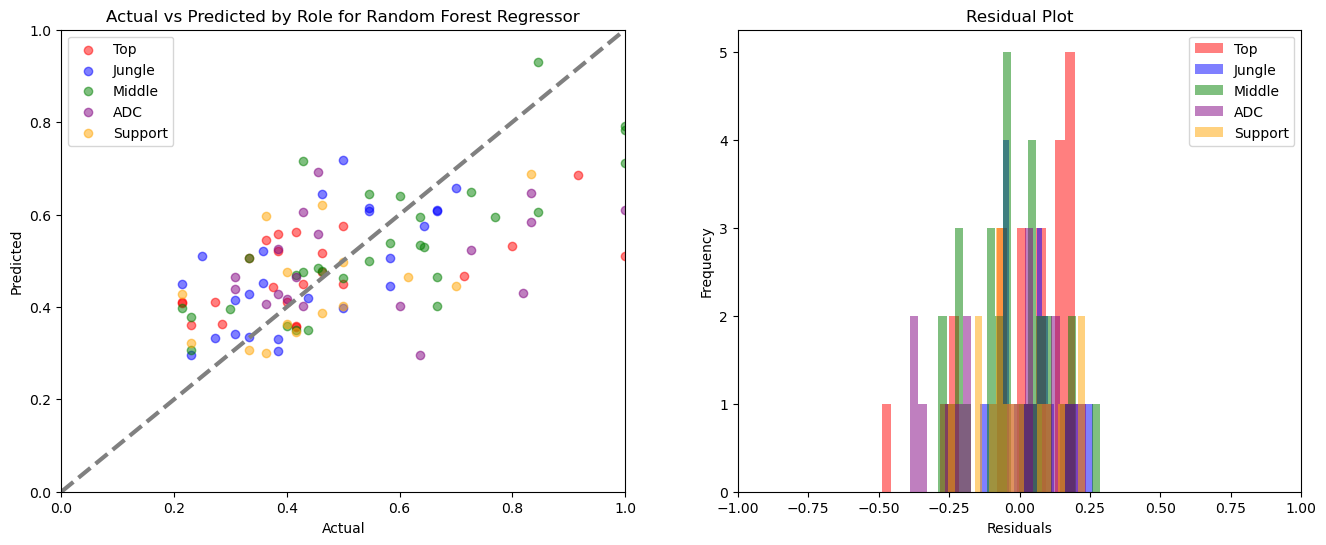

Metrics for Support Vector Regression
      Role      Loss      MAPE  R2 Score
0   Middle  0.039640  0.303817  0.182800
1   Jungle  0.030554  0.355398 -0.413069
2      ADC  0.064832  0.372758 -0.514759
3      Top  0.053013  0.351333 -0.249089
4  Support  0.027486  0.354807 -0.084401


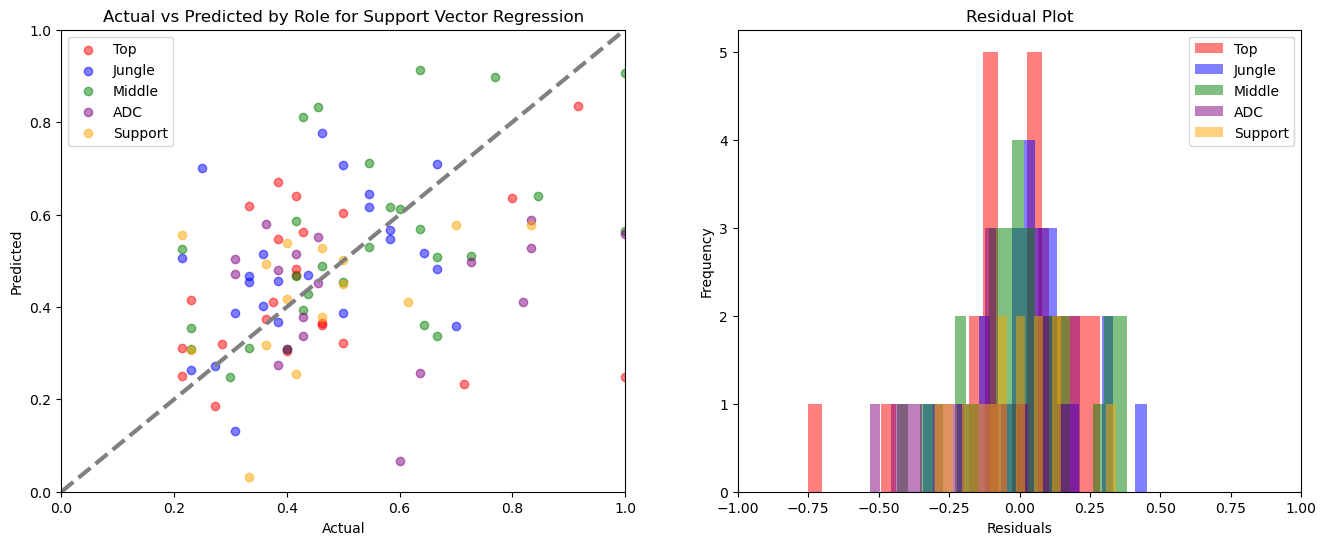

Metrics for KNN Regression
      Role      Loss      MAPE  R2 Score
0   Middle  0.031570  0.273575  0.349171
1   Jungle  0.027665  0.375644 -0.279459
2      ADC  0.047158  0.342834 -0.101803
3      Top  0.033248  0.313560  0.216623
4  Support  0.021070  0.256216  0.168723


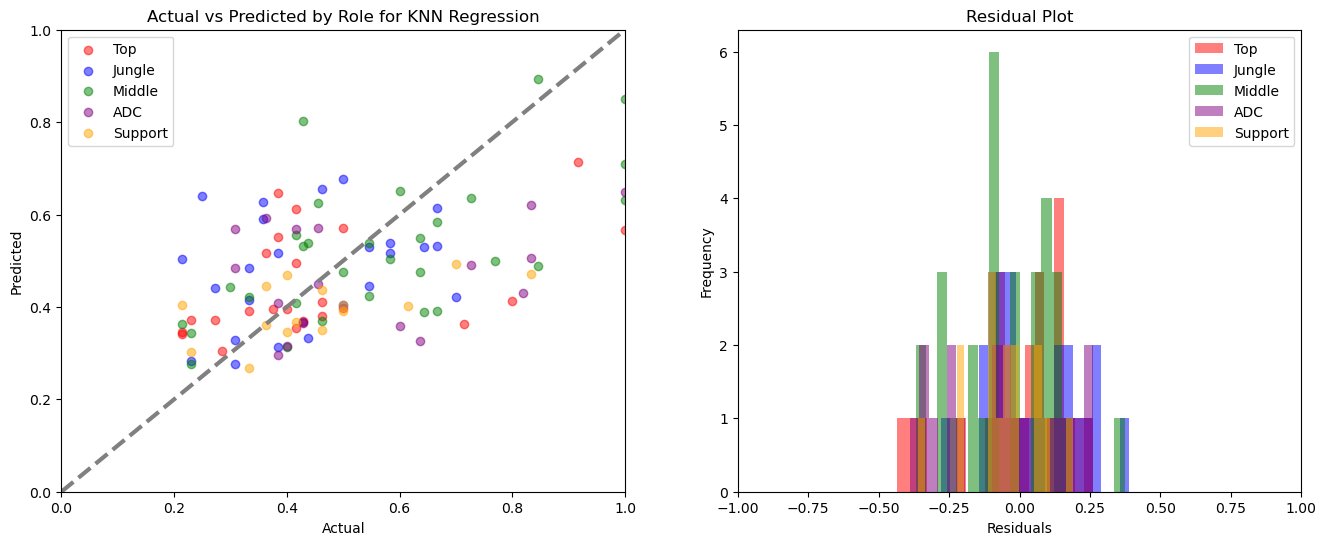

Metrics for Gausian Process Kernel
      Role      Loss      MAPE  R2 Score
0   Middle  0.066433  0.337685 -0.369567
1   Jungle  0.041148  0.461721 -0.903006
2      ADC  0.062710  0.413635 -0.465163
3      Top  0.080293  0.450932 -0.891842
4  Support  0.072885  0.497756 -1.875544


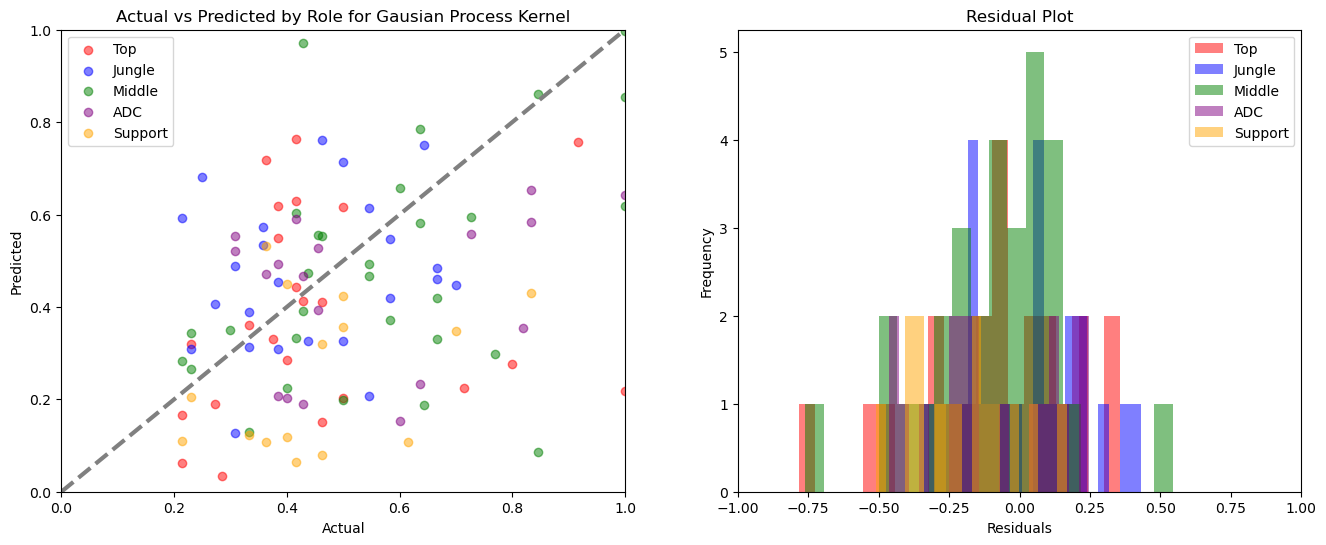

In [49]:
tml_scaled = {}
for key, value in normal_models.items():
    tml_scaled[key] = models_evaluations(scaled_input_args, value, key, 1)

Metrics for XGB Regressor
      Role      Loss      MAPE  R2 Score
0   Middle  0.039358  0.288326  0.188609
1   Jungle  0.019453  0.312618  0.100330
2      ADC  0.055674  0.304004 -0.300769
3      Top  0.044902  0.389559 -0.057980
4  Support  0.038359  0.325161 -0.513401


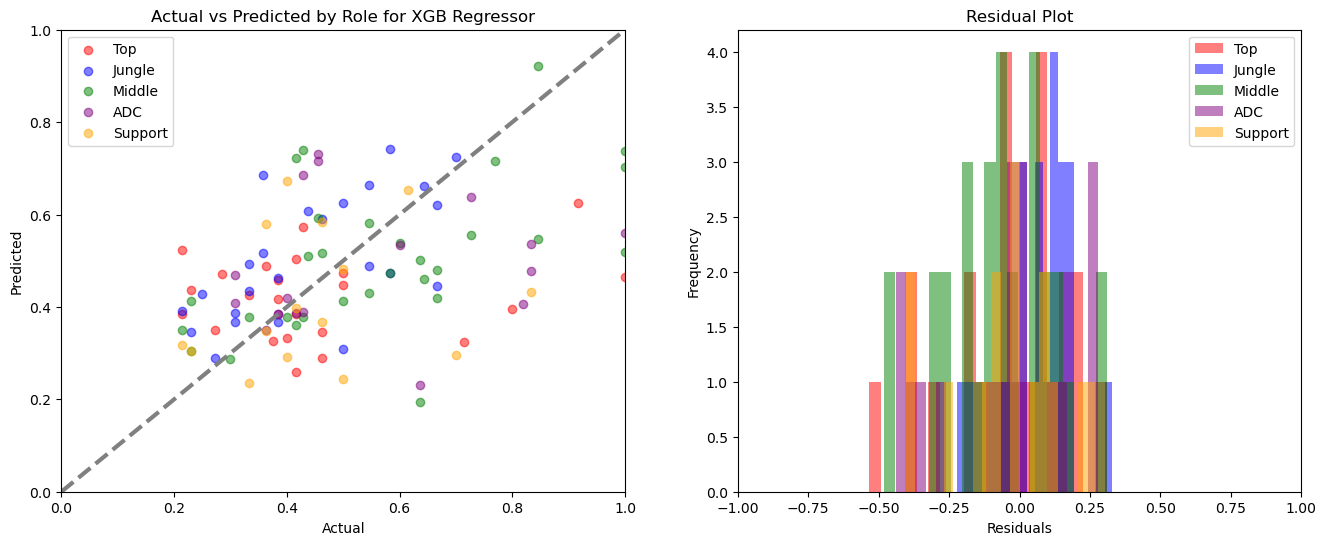

Metrics for Random Forest Regressor
      Role      Loss      MAPE  R2 Score
0   Middle  0.029724  0.269551  0.387221
1   Jungle  0.018555  0.329641  0.141858
2      ADC  0.051466  0.297840 -0.202456
3      Top  0.042566  0.375009 -0.002934
4  Support  0.036521  0.319952 -0.440862


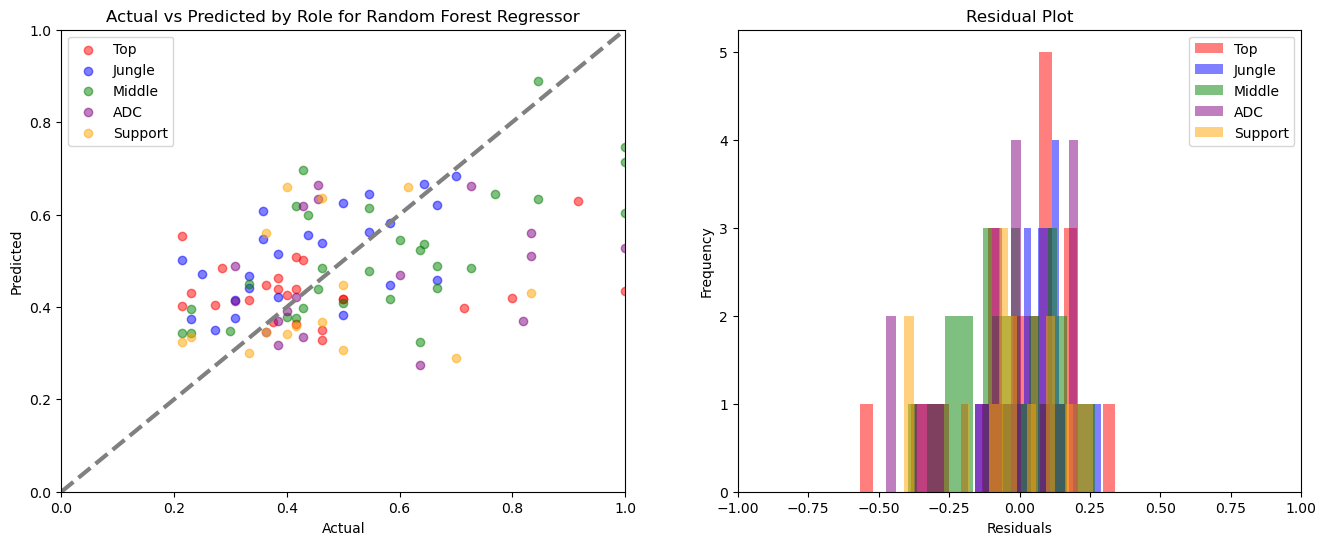

Metrics for Support Vector Regression
      Role      Loss      MAPE  R2 Score
0   Middle  0.047772  0.375037  0.015153
1   Jungle  0.022183  0.370771 -0.025935
2      ADC  0.051402  0.275255 -0.200962
3      Top  0.050001  0.465139 -0.178108
4  Support  0.027505  0.268271 -0.085147


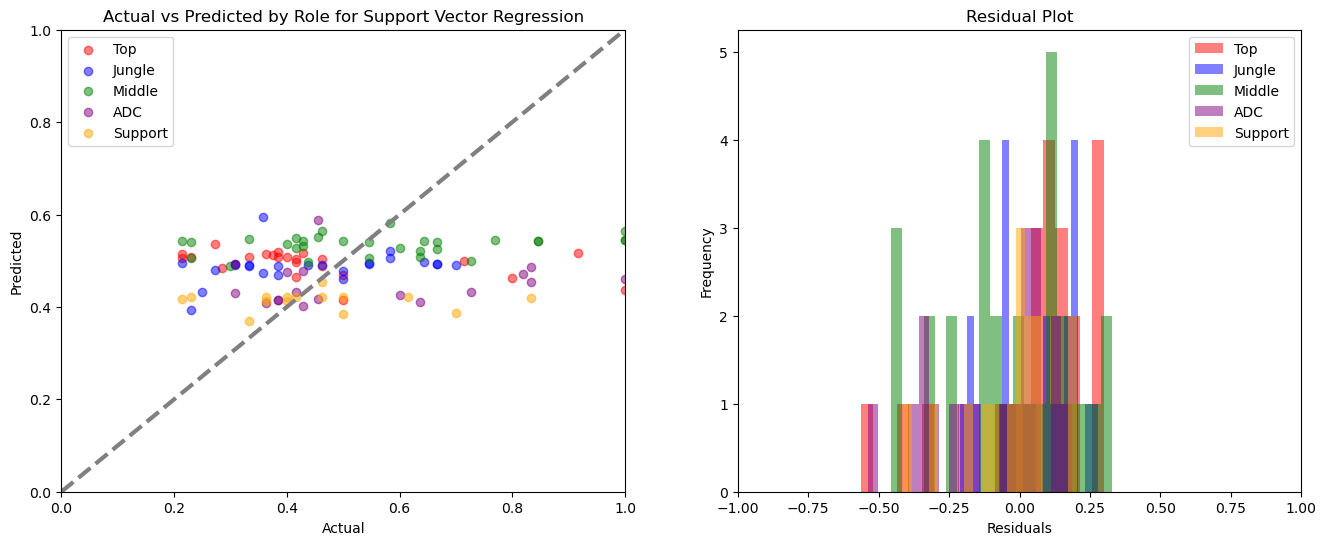

Metrics for KNN Regression
      Role      Loss      MAPE  R2 Score
0   Middle  0.032993  0.295209  0.319828
1   Jungle  0.024284  0.354653 -0.123068
2      ADC  0.047823  0.286846 -0.117346
3      Top  0.048141  0.362014 -0.134280
4  Support  0.034076  0.320882 -0.344422


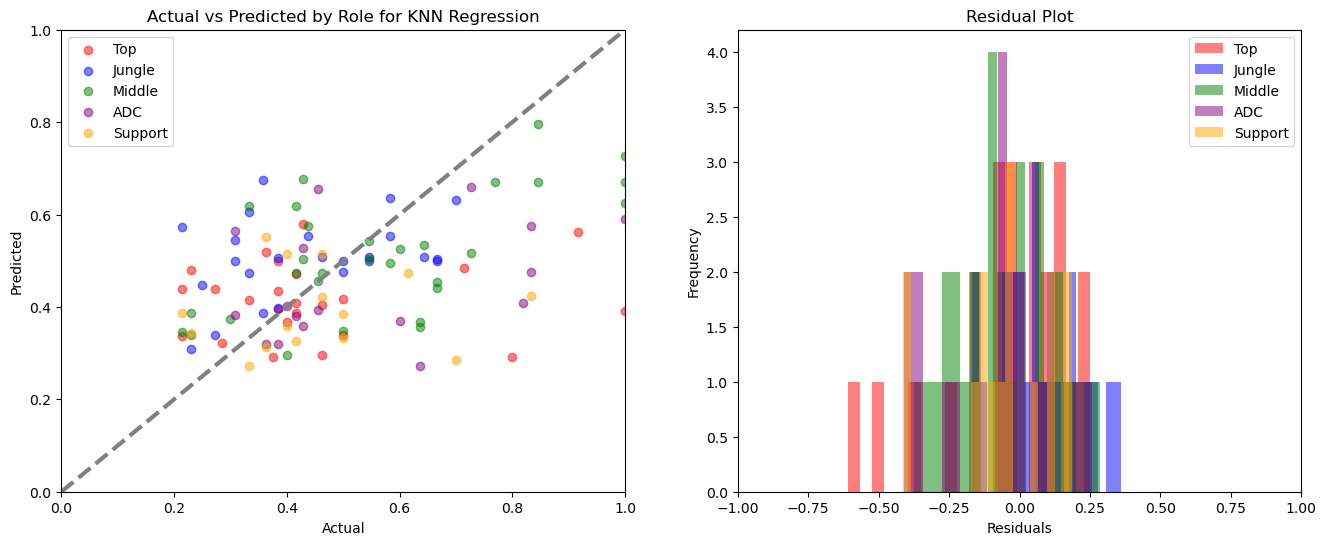

Metrics for Gausian Process Kernel
      Role      Loss      MAPE  R2 Score
0   Middle  0.161457  0.535341 -2.328541
1   Jungle  0.039869  0.401143 -0.843867
2      ADC  0.091453  0.401110 -1.136734
3      Top  0.115782  0.521774 -1.728020
4  Support  0.054218  0.372372 -1.139084


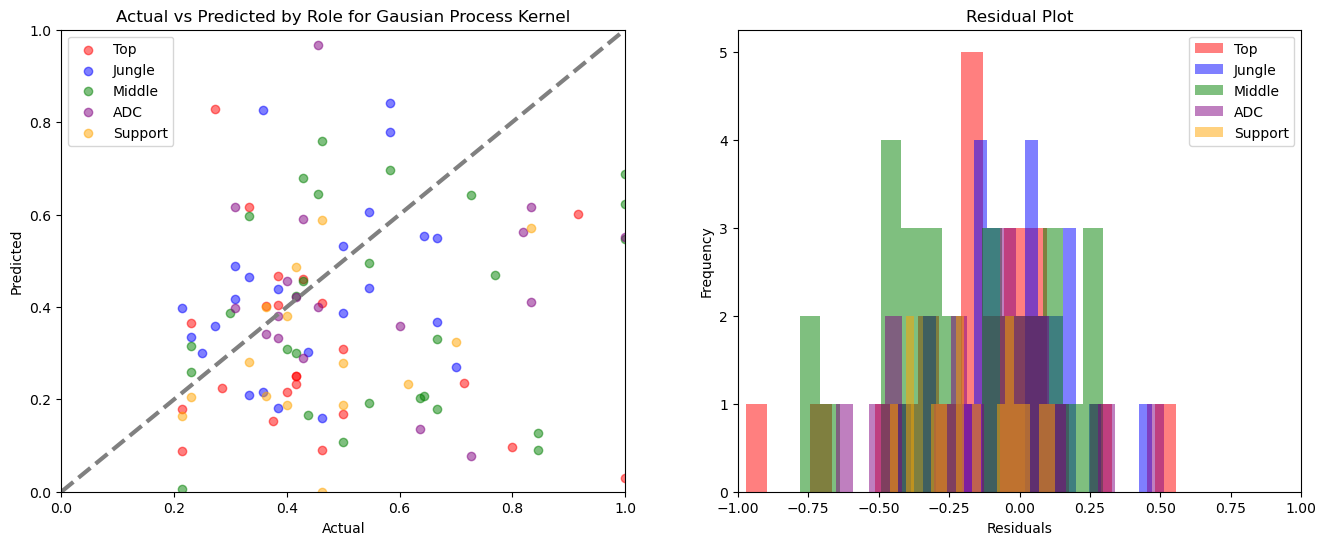

In [50]:
tml_unscaled = {}
for key, value in normal_models.items():
    tml_unscaled[key] = models_evaluations(unscaled_input_args, value, key, 1)

When using neural networks, the loss is typically low, but the MAPE is often high (around 80%). However, when using non-neural models like Random Forest Regression, Support Vector Regression, Gaussian Process Regression, and K-Nearest Neighbours Regression, the loss is ten times higher but the MAPE is lower (under 60%). This phenomenon may be due to the neural network overfitting the data or not having enough training examples. Non-neural models may be more robust and not suffer from these issues.

One key difference is where out neural networks show a MAPE of around 70% for the Support role, which is the only role where they perform better than our non-neural models. 



    However, this should not retract from the fact that both have terrible MAPE in general and do not perform well

The graph provide a visual indicator for how the models perform. We can utilize this to comment further on the wellness of the mode

Hmm, visual analysis of the graph immediately shows where the problem lies !

All the players with 0 MVP points in real are regularly being predicted to have actual values 

This seriously skews with the MAPE ratings, but keeps our loss generally the same

    So we take a a new test where we exclude inputs with actual values less than 0.2

    and try again. This gives an immediate increase in performance

We thus move on to making a voting regressor

In [33]:
from sklearn.ensemble import VotingRegressor
# We will use a stacked ensemble model to train our voting regressor
# Create a VotingRegressor with the list of models and their weights
trad_ml_models = list(normal_models.items())
ensemble_model = VotingRegressor(trad_ml_models, weights=[1.5, 1.8, 1.5, 1.5, 1])
ensemble_results = {}

In [53]:
def ensemble_stack_regressor(ensemble_model, neural_net_models, args, text="Stacked Ensemble", model_files=models_directory):
    values_list_by_roles, VIF_selected_features, labels_list_by_roles, positions = args[0], args[1], args[2], args[3]

    plotting_df = pd.DataFrame(columns=['Role', 'Actual', 'Predicted'])
    results = []
    role_models = {}
    
    # logic is -> get 5 models for each role as output, under the variable role_models
    # where the key is the role, and the value is the corresponding model
    # so for each role, we first get the x_train etc
    # then run the pre-trained neural models, take the output on X_TRAIN
    # augment the output of each as a feature 
    # (helps us interface kears sequential NN with scikit traditional ML models)
    # then run the ENSEMBLE MODEL on the augmented_x_train etc
    # run the metrics of loss and MAPE on the result. 
    # This final ensemble model will be the last one used
    
    os.chdir(model_files)
    
    print("Metrics for", text)
    for i in range(0, 5):
        role = positions[i]

        X_train, X_test, y_train, y_test = train_test_split(values_list_by_roles[i][VIF_selected_features[i]], 
                                                            labels_list_by_roles[i]['MVP'], 
                                                            test_size=0.2, random_state=42)
        
        X_train = X_train[y_train > 0.2]
        y_train = y_train[y_train > 0.2]
        X_test = X_test[y_test > 0.2]
        y_test = y_test[y_test > 0.2]
        
        # each value in nn_models contains the pre-fitted/trained models for the particular role
        # for eg, for the pair "Basic LSTM" : basic_lstm in nn_models
        # the contents of basic_lstm are -> {role : fitted_model for each role}
        X_train_augmented = X_train
        X_test_augmented = X_test
        for key, value in neural_net_models.items(): # key is the model name, value is the dictionary
            role_fittings_for_nn = value 
            # role_fittings_for_nn is a dictionary with the role as the key
            # and the value is the corresponding model's name in disk
            
            # get the pre-trained neural model for the current role
            model_addr = role_fittings_for_nn[role]
            model = load_model(model_addr)
            # get the output of the keras neural model on the training data
            nn_output_train = model.predict(X_train, verbose=0)
            nn_output_test = model.predict(X_test, verbose=0)
            
            # add the neural network output as a feature to the original training data
            X_train_augmented = np.hstack((X_train_augmented, nn_output_train))
            X_test_augmented = np.hstack((X_test_augmented, nn_output_test))
        
        # after adding all augmented features, fit the model for the role 
        ensemble_model.fit(X_train_augmented, y_train)
        
        
        # Calculate predictions and MAPE
        y_pred = ensemble_model.predict(X_test_augmented)
        # Evaluate model
        loss = mean_squared_error(y_true=y_test, y_pred=y_pred)
        mape = round(mean_absolute_percentage_error(y_test, y_pred), 2)
        r2 = r2_score(y_test, y_pred=y_pred)
        results.append([role, loss, mape, r2])
        final_model_name = text.replace(" ","_") + "_" +role+".joblib"
        dump(ensemble_model, final_model_name)
        role_models[role] = final_model_name
        
        actual = y_test.values
        predicted = y_pred.ravel()
        plotting_df = plotting_df.append(pd.DataFrame({'Role': role, 
                                                       'Actual': actual,
                                                       'Predicted': predicted}), ignore_index=True)
    
    df = pd.DataFrame(results, columns=['Role', 'Loss', 'MAPE', 'R2 Score'])
    print(df)
    
    make_double_plot(plotting_df=plotting_df, text=text)
    
    return role_models    
    

Metrics for Stacked Ensemble
      Role      Loss  MAPE  R2 Score
0   Middle  0.030507  0.27  0.371079
1   Jungle  0.020048  0.31  0.072823
2      ADC  0.048898  0.32 -0.142458
3      Top  0.035932  0.30  0.153369
4  Support  0.021306  0.27  0.159419


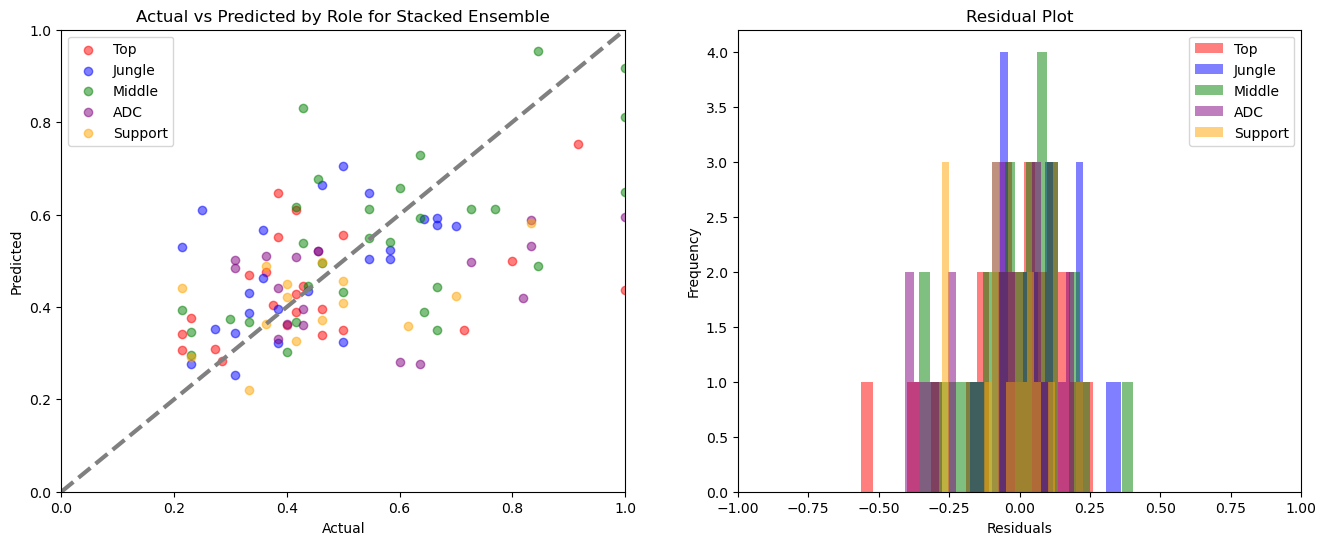

In [54]:
ensemble_results = ensemble_stack_regressor(ensemble_model, nn_scaled, scaled_input_args)

We now use this ensemble model as the final piece of our rankings. We will take the ranking achieved from this, and the ranking achieved from raw %ile in each of the important stats for a given role, to create a final ranking for players by their respective role

Metrics for Uncaled Ensemble
      Role      Loss  MAPE  R2 Score
0   Middle  0.031995  0.27  0.340399
1   Jungle  0.013535  0.27  0.374016
2      ADC  0.051400  0.29 -0.200929
3      Top  0.050608  0.39 -0.192414
4  Support  0.024971  0.25  0.014792


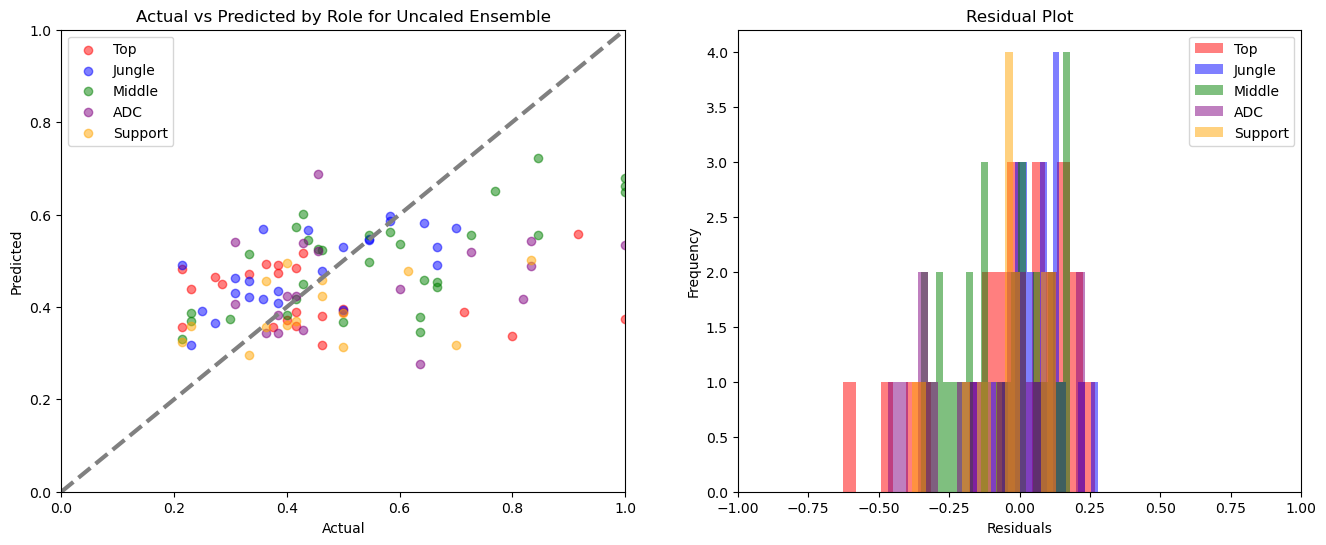

In [55]:
unscaled_ensemble_results = ensemble_stack_regressor(ensemble_model, nn_unscaled, unscaled_input_args, text="Uncaled Ensemble")

In [37]:
# now ranking the Spring 2023 roster data
os.chdir(os.path.join(og_dir, "spring23 LCK"))

player_data = pd.read_csv('LCK 2023 Spring.csv')
mvp_data = pd.read_csv('mvp_data.csv')

os.chdir(os.path.join(og_dir, "model_files"))
# create a new column called "MVP" in the player_data dataframe
player_data["MVP"] = 0

# iterate over each row in the MVP data dataframe
for index, row in mvp_data.iterrows():
    # check if the player's name exists in the player_data dataframe
    if row["Player"] in player_data["Player"].values:
        # if so, find the row with the player's name and update the "MVP" column with the MVP points
        player_data.loc[player_data["Player"] == row["Player"], "MVP"] = row["Points"]

player_data['Year'] = "2023"
player_data['Season'] = "Spring"

exclude = ['Player', 'Team', 'Pos', 'Year', 'Season']
incldue = [col for col in player_data.columns if col not in exclude]
for cols in incldue:
    for idx, val in player_data[cols].items():
        if str(val).endswith("%"):
            player_data.at[idx, cols] = str(val.strip("%"))

player_data[incldue] = player_data[incldue].astype('float64')

rank_test = scale_split(player_data)
rank_test = rank_test.dropna(axis=1)
rank_test_vals = rank_test.select_dtypes(include='number')
rank_test_vals = rank_test_vals.drop(['GP', 'MVP'], axis=1)
rank_test_labels = rank_test.select_dtypes(exclude='number')
rank_test_labels = pd.concat([rank_test_labels, rank_test[['GP', 'MVP']]], axis=1)

role_rank_test = []
role_rank_test_labels = []
role_rank_test_vals = []
# generating 5 sets of data for players in each role
for position in positions:
    role_rank_test.append(rank_test[rank_test['Pos'] == position])
    role_rank_test_labels.append(rank_test_labels[rank_test_labels['Pos'] == position])
    role_rank_test_vals.append(rank_test_vals[rank_test_labels['Pos'] == position])
    
role_rank_test[positions.index("ADC")].sort_values(by=['KDA', 'W%', 'DMG%'], ascending=False).head()

,Player,Team,Pos,GP,W%,CTR%,K,D,A,KDA,...,D%P15,EGPM,GOLD%,STL,WPM,CWPM,WCPM,MVP,Year,Season
15,Aiming,KT Rolster,ADC,0.87500,0.746032,0.688889,0.771144,0.054348,0.276657,0.924528,...,1.000000,1.000000,0.994924,0.000000,0.093960,0.024390,0.714286,0.461538,2023,Spring
8,Deft,Dplus KIA,ADC,0.78125,0.746032,1.000000,0.786070,0.108696,0.308357,0.867925,...,0.969925,0.987603,1.000000,0.142857,0.100671,0.073171,0.547619,0.307692,2023,Spring
28,Peyz,Gen.G,ADC,0.87500,0.825397,0.288889,1.000000,0.239130,0.371758,0.830189,...,0.875940,0.995868,0.923858,0.000000,0.100671,0.024390,0.642857,0.461538,2023,Spring
22,Gumayusi,T1,ADC,0.87500,1.000000,0.333333,0.815920,0.358696,0.446686,0.660377,...,0.812030,1.000000,0.898477,0.142857,0.080537,0.121951,0.476190,0.230769,2023,Spring
44,Viper,Hanwha Life Esports,ADC,0.93750,0.555556,0.444444,0.606965,0.250000,0.296830,0.528302,...,0.969925,0.900826,0.949239,0.000000,0.114094,0.170732,0.595238,0.615385,2023,Spring


In [38]:
def rankings(role_rank_test, relevant_cols, positions):
    ranks = {}
    for role in positions:
        # print(role)
        relevant = relevant_cols[positions.index(role)]
        # print(relevant)
        rankings_dict = {}
        temp_data = role_rank_test[positions.index(role)]
        
        for player in temp_data["Player"]:
            player_rankings = []
            for col in list(relevant):
                # print(col, "\n")
                sorted_data = temp_data.sort_values(by=col, ascending=(col in ["D"])).reset_index()
                # print(sorted_data["Player"])
                player_rank = sorted_data.index[sorted_data['Player'] == player].tolist()[0] + 1
                player_rankings.append(player_rank)
            rankings_dict[player] = mean(player_rankings)
        ranks[role] = rankings_dict
    return ranks

In [39]:
percentile_ranks = rankings(role_rank_test, relevant_cols, positions)

# convert the float 'ranks' to actual ranks from 1 to 10/11
for role, players in percentile_ranks.items():
    # sort the players based on their scores in descending order
    sorted_players = sorted(players, key=players.get, reverse=False)
    # create a new dictionary to store the rankings
    rankings = {}
    # assign rankings to each player based on their position in the sorted list
    for i, player in enumerate(sorted_players):
        rankings[player] = i + 1
    # replace the original scores with the rankings
    percentile_ranks[role] = rankings


In [40]:
def ensemble_rankings(args, ensemble_models, neural_net_models):
    role_rank_test = args[0]
    releveant_cols = args[1]
    positions = args[2]
    ranks = {}
    for role in positions:
        ensemble_model = ensemble_models[role]
        relevant = releveant_cols[positions.index(role)]
        rankings_dict = {}
        players = role_rank_test[positions.index(role)]["Player"]
        temp_data = role_rank_test[positions.index(role)][relevant]
        
        # augmenting with the nn stack
        temp_data_augmented = temp_data
        for key, value in neural_net_models.items(): # key is the model name, value is the dictionary
            role_fittings_for_nn = value 
            # role_fittings_for_nn is a dictionary with the role as the key
            # and the value is the corresponding model's name in disk
            
            # get the pre-trained neural model for the current role
            model_addr = role_fittings_for_nn[role]
            model = load_model(model_addr)
            # get the output of the keras neural model on the training data
            nn_output = model.predict(temp_data, verbose=0)
            
            # add the neural network output as a feature to the original training data
            temp_data_augmented = np.hstack((temp_data_augmented, nn_output))
        
        # predict with ensemble model
        predictions = ensemble_model.predict(temp_data_augmented)
        rankings_dict = {player: rank for player, rank in zip(players, predictions)}
        sorted_players = sorted(rankings_dict, key=rankings_dict.get, reverse=True)
        rankings = {}
        for i, player in enumerate(sorted_players):
            rankings[player] = i + 1
            
        ranks[role] = rankings
    return ranks

In [41]:
testing_ensemble_args = [role_rank_test, relevant_cols, positions]
os.chdir(os.path.join(og_dir, 'model_files'))
top_ensem = load('Stacked_Ensemble_Top.joblib')
sup_ensem = load('Stacked_Ensemble_Support.joblib')
adc_ensem = load('Stacked_Ensemble_ADC.joblib')
mid_ensem = load('Stacked_Ensemble_Middle.joblib')
jgl_ensem = load('Stacked_Ensemble_Jungle.joblib')

ensemble_models = {
    'Top': top_ensem,
    'Support': sup_ensem,
    'ADC': adc_ensem,
    'Middle': mid_ensem,
    'Jungle': jgl_ensem
}

In [42]:
ensemble_ranks = ensemble_rankings(testing_ensemble_args, ensemble_models, nn_scaled)

In [43]:
# now to get the MVP ranks
mvp_ranks = {}
for role in positions:
    temp_players = role_rank_test[positions.index(role)][["Player", "MVP"]]
    temp_players = temp_players.sort_values(by="MVP", ascending=False).reset_index()

    # create a new dictionary to store the rankings
    rankings = {}
    # assign rankings to each player based on their position in the sorted db
    for i, row in temp_players.iterrows():
        rankings[row["Player"]] = i + 1
    # replace the original scores with the rankings
    mvp_ranks[role] = rankings

In [44]:
# combine the three ranks into one
final_evaluation = {}

for role in positions:
    mvp_rankings = mvp_ranks[role]
    ensemble_rankings = ensemble_ranks[role]
    percentile_rankings = percentile_ranks[role]

    # Combine the rankings using a suitable method, such as averaging
    combined_rankings = {}

    for player in mvp_rankings:
        # Compute the average rank of the player across the three structures
        avg_rank = (mvp_rankings[player] + ensemble_rankings[player] + percentile_rankings[player]) / 3

        # Add the player and their average rank to the combined rankings
        combined_rankings[player] = avg_rank
    sorted_ranks = sorted(combined_rankings, key=combined_rankings.get, reverse=False)
    rankings = {}
    for i, player in enumerate(sorted_ranks):
        rankings[player] = i + 1
        
    # Store the combined rankings for the position in the final_evaluation dictionary
    final_evaluation[role] = rankings


In [45]:
final_evaluation

{'Middle': {'Chovy': 1,
  'ShowMaker': 2,
  'Faker': 3,
  'Clozer': 4,
  'Bdd': 5,
  'ZEKA': 6,
  'BuLLDoG': 7,
  'Karis': 8,
  'FIESTA': 9,
  'FATE': 10},
 'Jungle': {'Oner': 1,
  'Canyon': 2,
  'Peanut': 3,
  'Cuzz': 4,
  'Willer': 5,
  'Clid': 6,
  'UmTi': 7,
  'Juhan': 8,
  'Sylvie': 9,
  'Croco': 10,
  'YoungJae': 11},
 'ADC': {'Viper': 1,
  'Deft': 2,
  'Peyz': 3,
  'Envyy': 4,
  'Aiming': 5,
  'Gumayusi': 6,
  'Taeyoon': 7,
  'Hena': 8,
  'vital': 9,
  'deokdam': 10},
 'Top': {'Kiin': 1,
  'Doran': 2,
  'DuDu': 3,
  'Zeus': 4,
  'Canna': 5,
  'Rascal': 6,
  'Morgan': 7,
  'DnDn': 8,
  'Burdol': 9,
  'Kingen': 10},
 'Support': {'Keria': 1,
  'Kael': 2,
  'Kellin': 3,
  'Delight': 4,
  'Lehends': 5,
  'Moham': 6,
  'BeryL': 7,
  'Life': 8,
  'Peter': 9,
  'Jun': 10,
  'Effort': 11}}

In [46]:
# Working on polar graphs for Given player vs Rank 1 Player or any given Player
import plotly.graph_objects as go

# data for the radar chart

player_name = "Gumayusi"
comparison = 1 # rank of the player to be compared with, default 1
comparison_name = "" # name of the player. ideally, feed either or
# get the row for the player from the DataFrame
player_row = player_data[player_data["Player"] == player_name]

player_role = player_row["Pos"].iloc[0]
polar_relevant = relevant_cols[positions.index(player_role)]
for key, value in final_evaluation[player_role].items():
    if value == comparison:
        comparison_name = key
comaprison_row = player_data[player_data["Player"] == comparison_name]


player_percentiles = []
comparison_percentiles = []
max_percentiles = [1 for col in polar_relevant]
# Get the percentiles for the player's role
role_data = player_data[player_data["Pos"] == player_role]
for col in polar_relevant:
    max_val = role_data[col].max()
    player_val = player_row[col].iloc[0]
    player_percentiles.append(player_val / max_val)
    comp_val = comaprison_row[col].iloc[0]
    comparison_percentiles.append(comp_val / max_val)
# get the list of all players with the same "Pos"
# For col in relevant cols ->
    # sort them by col, then take greatest value in the given col and value of the given player
    # store the percentage values for given player (basically just the ratio)
    # do the same for the comparison player, and store in the separate list

fig = go.Figure()

# add the max values to set the background
fig.add_trace(go.Scatterpolar(
      r=max_percentiles,
      theta=list(polar_relevant),
      fill='toself',
      name='Max Value amongst Players'
))

# add the player's data to the chart
fig.add_trace(go.Scatterpolar(
      r=player_percentiles,
      theta=list(polar_relevant),
      fill='toself',
      name='Player Scores for ' + player_name
))

# add the comparison percentiles to the chart
fig.add_trace(go.Scatterpolar(
      r=comparison_percentiles,
      theta=list(polar_relevant),
      fill='toself',
      name='Scores for rank ' + str(comparison) + ' : ' + comparison_name
))

# customize the layout of the chart
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]
        )
    ),
    showlegend=True
)

# show the chart
fig.show()


For validation, we can further compare our model based rankings with the LCK Spring 2023 All-Pro team.

The All-Pro Teams selection process involves voting by a panel of industry experts, media representatives, and fans to identify the top-performing players in various positions over the course of the Spring Split season. The awards are presented to players who have demonstrated exceptional skill and performance in their respective roles, based on a range of criteria such as in-game statistics, strategic value, and overall impact on the game. Getting an All-Pro Teams recognition is highly regarded and is considered a significant achievement for players and teams in the LCK.

    MVP : Keria , Player of the Split : Keria

    First All Pro-Team : Zeus, Oner, Faker, Gumayusi, Keria

    Second All Pro-Team : Kiin, Peanut, Chovy, Deft, Kellin

    Third All Pro-Team : Doran, Canyon, Bdd, Peyz, Lehends

For our rankings, we can create the following teams :

    First All Pro-Team (Model) : Kiin, Oner, Chovy, Viper, Keria

    Second All Pro-Team (Model) : Doran, Peanut, ShowMaker, Deft, Kael

    Third All Pro-Team (Model) : DuDu, Canyon, Faker, Peyz, Kellin

We can see an overlap of the following players within the top 3 for each role :
    
    Top : Kiin, Doran 

(Zeus is 4th in our rankings, DuDu is taken instead as third, pushing the other two one place higher)

    Jungle : Oner, Peanut, Canyon

(Interestingly, the exact order of rankings is also maintained)

    Middle : Chovy, Faker

(Their rankings are inverted, and Bdd is replaced with ShowMaker. Again, Bdd makes a close 4th on our list)

    Bottom : Deft, Peyz

(Both maintain 2nd and 3rd spot, but the first spot is replaced with Viper. Surprisingly, Gumayusi is a far 6th place on our list. This may be the result of nuances or other factors that our model does not account for)

    Support : Keria, Kellin

(Lehends appears 5th on our list, and Kael pushes into the top 3 instead)


Overall, there are many interesting factoids and things of note from this split, the key one I wish to mention is that the team 'T1' are just straight up the First All-Pro Team. Coming from a close 3-2 defeat in a Best of 5 game at the 2022 Worlds', T1 have appeared equally stellar for the Spring 2023 split and sweeped the competition with a 17-1 W/L record in the LCK's double round robin format. 

This may be a possible cause of why T1 players are extremely highly ranked by experts, while our model which only looks at raw stats is not able to find much of a difference. 